In [1]:
%reload_ext autoreload
%autoreload 2

In [33]:
from os import listdir
from pathlib import Path
base_path = '/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs-final'
dirs = listdir(base_path)
times = []
for d in dirs:
    if Path.is_file(Path(f'{base_path}/{d}/times.csv')):
        times.append(pd.read_csv(f'{base_path}/{d}/times.csv', sep=', ').iloc[0].sum())

/storage/plzen1/home/tslaninakova/.conda/envs/lmi/lib/python3.6/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [34]:
np.mean(times), np.std(times), np.max(times)

(97662.32272367478, 228449.1431180483, 1738392.4330439568)

In [35]:
np.min(times)

369.7253894805908

In [32]:
pd.read_csv('/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs-final/CoPhIR-1M-GMM--2022-04-25--07-48-47/times.csv', sep=', ').iloc[0].sum()

/storage/plzen1/home/tslaninakova/.conda/envs/lmi/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


3387.3140130043025

In [3]:
!pip install faiss-cpu

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmi.utils import load_yaml, load_model_config
from lmi.data.DataLoader import ProfisetDataLoader, CoPhIRDataLoader, MocapDataLoader

In [11]:
config_file = './supplementary-experiment-setups/100k/CoPhIR-100k-Mtree-200-LR.yml'

In [12]:
config = load_yaml(config_file)
config

{'setup': 'exp-100k',
 'data': {'data-dir': '../../datasets',
  'dataset': 'COPHIR',
  'dataset-size': '100k',
  'original': {'index': 'MTREE', 'leaf-node-capacity': 200},
  'normalize': True,
  'shuffle': True,
  'shuffle-seed': 1},
 'LMI': {'model-config': 'supplementary-experiment-setups/100k/models/CoPhIR-100k-Mtree-200-LR-model.yml',
  'training-dataset-percentage': 1},
 'experiment': {'gt-subdir': 'ground-truths',
  'output-dir': 'outputs',
  'search-stop-conditions': [0.0005,
   0.001,
   0.003,
   0.005,
   0.01,
   0.05,
   0.1,
   0.2,
   0.3,
   0.5],
  'knns': 30,
  'queries-out-of-dataset': False}}

In [13]:
from lmi.data.DataLoader import CoPhIRDataLoader
loader = CoPhIRDataLoader(config)
descriptors = loader.load_descriptors()

[2022-07-11 14:15:13,068][INFO ][lmi.data.DataLoader] Loading CoPhIR dataset from ../../datasets\datasets\CoPhIR100k-descriptors.csv.


In [17]:
descriptors[0].to_csv('C:\\phdspace\\code\\dynamic-learned-indexes\\cophir-100k.csv', index=None)

In [25]:
from lmi.data.DataLoader import ProfisetDataLoader
loader = ProfisetDataLoader(config)
descriptors = loader.load_descriptors()
labels = loader.load_labels()
knns = loader.get_knn_ground_truth()
queries = loader.get_queries()

[2022-06-28 10:17:42,867][INFO ][lmi.data.DataLoader] Loading Profiset/MoCap dataset from /storage/brno12-cerit/home/tslaninakova/data/datasets/Profiset100k-descriptors.csv.


In [6]:
from lmi.distances.euclidean import get_euclidean_distance
from lmi.distances.cophir import get_cophir_distance

## Leaf nodes, revisited:

- classification approach where 1 object == 1 category (1 ML model on leaf node)

### Experiment 1 -- Can we successfully recognize the nearest neighbor present in a leaf node?
- 199 random objects in a leaf node, 1 of the objective 30 nearest neighbors of `query`
- 'search' (= predict) with `query`

In [16]:
import random
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


Inserting the NN (170782) (21-th k-NN) for 671744 at the 66-th position
Predicted closest object: 66, p=0.6002920866012573


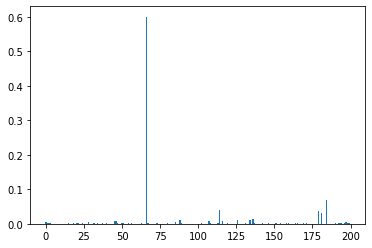

Inserting the NN (165891) (8-th k-NN) for 165889 at the 178-th position
Predicted closest object: 178, p=0.9821887612342834


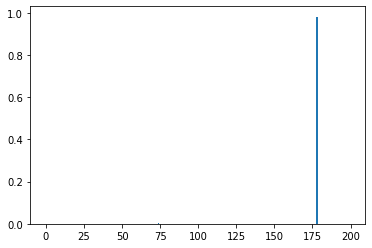

Inserting the NN (140639) (2-th k-NN) for 45059 at the 79-th position
Predicted closest object: 79, p=0.2929183840751648


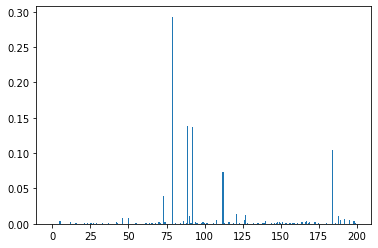

Inserting the NN (676820) (10-th k-NN) for 550605 at the 177-th position
Predicted closest object: 177, p=0.4406798481941223


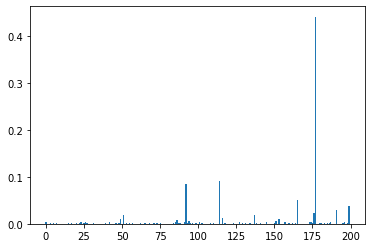

Inserting the NN (268) (12-th k-NN) for 496278 at the 158-th position
Predicted closest object: 158, p=0.4095332622528076


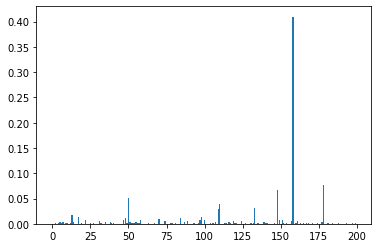

Inserting the NN (21376) (13-th k-NN) for 83978 at the 1-th position
Predicted closest object: 1, p=0.2532009780406952


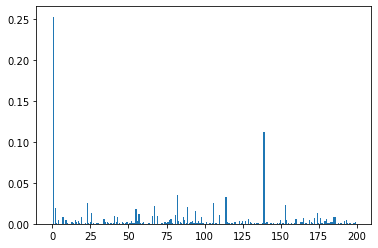

Inserting the NN (31784) (29-th k-NN) for 143373 at the 126-th position
Predicted closest object: 168, p=0.18655504286289215


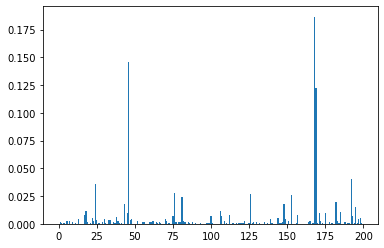

Inserting the NN (114001) (8-th k-NN) for 55310 at the 64-th position
Predicted closest object: 64, p=0.22516430914402008


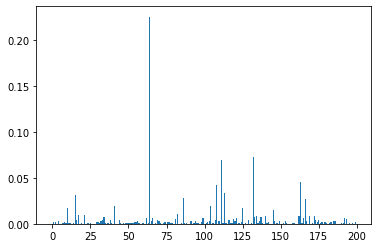

Inserting the NN (153822) (24-th k-NN) for 65552 at the 80-th position
Predicted closest object: 80, p=0.32048025727272034


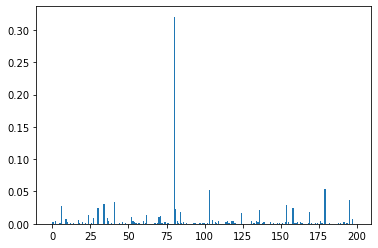

Inserting the NN (81990) (27-th k-NN) for 112984 at the 157-th position
Predicted closest object: 46, p=0.2302301824092865


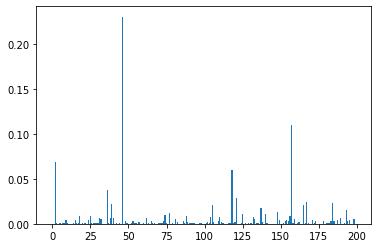

In [12]:
keys = list(knns.keys())[:10]
def pick_random_nn(key):
    rand_nn_index = random.randint(1, 29)
    #print(f'For {key}, picked out {rand_nn_index}-th nearest neighbor to look for.')
    return rand_nn_index, int(sorted(knns[key].items(), key=lambda kv: kv[1])[rand_nn_index][0])

def train_collect_preds(data, query):
    model = tf.keras.Sequential([
        layers.Dense(input_shape=[4096,], units=200, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy')

    model.fit(data_in_leaf_node, np.arange(0, 200, 1), epochs=100, verbose=0)
    return model.predict(query.reshape(1, -1))

for key in keys:
    rand_cutoff = random.randint(0, 200)
    rand_nn_index, nn = pick_random_nn(key)
    data1 = descriptors.sample(rand_cutoff).values
    data2 = descriptors.sample(200 - rand_cutoff - 1).values
    print(f'Inserting the NN ({nn}) ({rand_nn_index}-th k-NN) for {key} at the {rand_cutoff}-th position')
    data_in_leaf_node = np.vstack((data1, descriptors.loc[nn].values, data2))
    preds = train_collect_preds(data_in_leaf_node, descriptors.loc[int(key)].values)
    print(f'Predicted closest object: {np.argmax(preds)}, p={np.max(preds)}')
    plt.bar(np.arange(0, 200, 1), preds[0])
    plt.show()

### Experiment 2 -- Can we recognize multiple nearest neighbors (5) for query?

Inserting the NN ([75461, 660805, 150811, 56179, 429982]) ([27, 9, 29, 15, 8]-th k-NNs) for 671744 at positions: [154, 195, 105, 132, 29]
Predicted 5 closest objects: [141  29 105  99 154], p=[0.14629565 0.12523568 0.11960486 0.11188941 0.06585138]


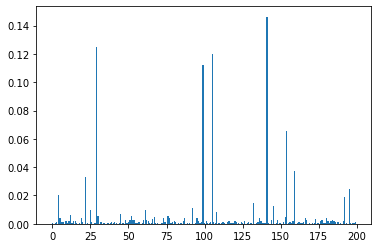

Inserting the NN ([302078, 136056, 310039, 135089, 161003]) ([2, 18, 22, 29, 5]-th k-NNs) for 165889 at positions: [16, 198, 147, 39, 158]
Predicted 5 closest objects: [158 198  16 120 147], p=[0.3882849  0.2831596  0.28194362 0.01564562 0.00882453]


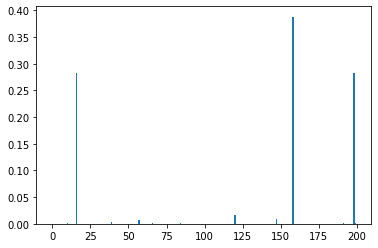

Inserting the NN ([77092, 145256, 140639, 28132, 97490]) ([15, 27, 2, 13, 11]-th k-NNs) for 45059 at positions: [162, 57, 182, 0, 119]
Predicted 5 closest objects: [  0  30  57 119 182], p=[0.4049259  0.10311041 0.07843827 0.05093183 0.03472726]


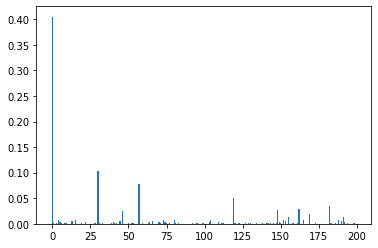

Inserting the NN ([98062, 594530, 659428, 97750, 671972]) ([22, 14, 11, 8, 7]-th k-NNs) for 550605 at positions: [115, 159, 137, 177, 6]
Predicted 5 closest objects: [  6 137 115  57 159], p=[0.5787763  0.09304153 0.06165197 0.05051724 0.0325575 ]


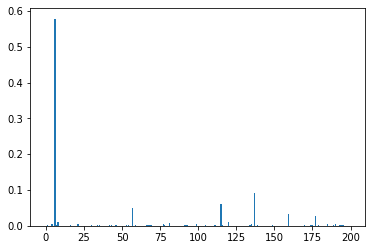

Inserting the NN ([1379, 268, 7393, 27419, 496274]) ([4, 12, 20, 29, 5]-th k-NNs) for 496278 at positions: [62, 98, 21, 141, 144]
Predicted 5 closest objects: [144  62  21  98 141], p=[0.4948235  0.25866336 0.06189331 0.05532613 0.03168455]


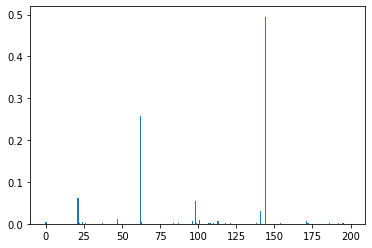

Inserting the NN ([59627, 113264, 520352, 111639, 111493]) ([28, 19, 6, 22, 24]-th k-NNs) for 83978 at positions: [102, 141, 67, 162, 120]
Predicted 5 closest objects: [ 67 141  87 162 120], p=[0.28227702 0.13702378 0.06419925 0.06146225 0.06088793]


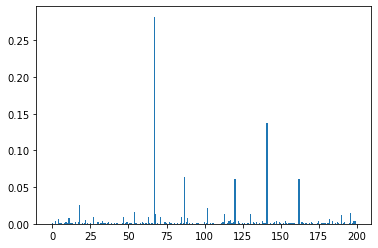

Inserting the NN ([231000, 101693, 593721, 315418, 135932]) ([5, 15, 24, 25, 19]-th k-NNs) for 143373 at positions: [13, 88, 197, 111, 20]
Predicted 5 closest objects: [197 111  92  20 114], p=[0.49491012 0.11969817 0.10485629 0.05290861 0.03908534]


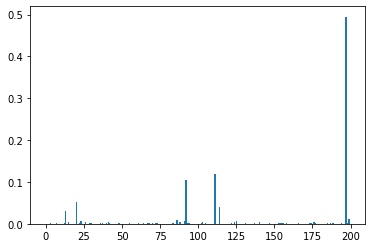

Inserting the NN ([51324, 174104, 35773, 45106, 159553]) ([19, 23, 20, 29, 28]-th k-NNs) for 55310 at positions: [194, 100, 141, 71, 17]
Predicted 5 closest objects: [ 71 141  76 100  17], p=[0.32725307 0.24769998 0.08594653 0.07063924 0.03988156]


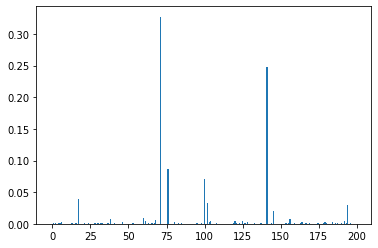

Inserting the NN ([15784, 111029, 272473, 25987, 140566]) ([18, 29, 3, 20, 19]-th k-NNs) for 65552 at positions: [29, 9, 60, 166, 134]
Predicted 5 closest objects: [ 60   9  29 166 134], p=[0.51710814 0.10864469 0.09388597 0.0581518  0.02217031]


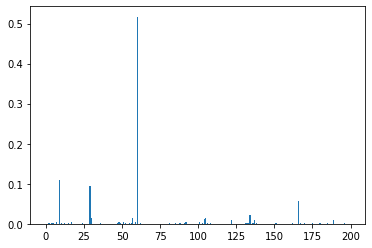

Inserting the NN ([128697, 118600, 41916, 159469, 145188]) ([15, 16, 1, 2, 23]-th k-NNs) for 112984 at positions: [61, 82, 5, 164, 183]
Predicted 5 closest objects: [  5 164  61  68 194], p=[0.724131   0.14729418 0.02468734 0.02221743 0.01452118]


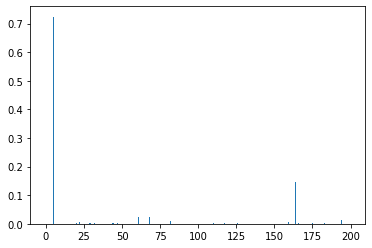

In [38]:
keys = list(knns.keys())[:10]
def pick_random_nns(key):
    picked_out_indexes = []
    while len(picked_out_indexes) != 5:
        rand_nn_index = random.randint(1, 29)
        if rand_nn_index not in picked_out_indexes:
            picked_out_indexes.append(rand_nn_index)
    #print(f'For {key}, picked out {rand_nn_index}-th nearest neighbor to look for.')
    return picked_out_indexes, [int(sorted(knns[key].items(), key=lambda kv: kv[1])[rand_nn_index][0]) for rand_nn_index in picked_out_indexes]

def train_collect_preds(data, query):
    model = tf.keras.Sequential([
        layers.Dense(input_shape=[4096,], units=200, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy')

    model.fit(data_in_leaf_node, np.arange(0, 200, 1), epochs=100, verbose=0)
    return model.predict(query.reshape(1, -1))

for key in keys:
    rand_nn_indexes, nns = pick_random_nns(key)
    rand_cutoff = random.randint(0, 200)
    data = pd.concat([descriptors.sample(195), descriptors.loc[nns]])
    data = data.sample(frac=1)
    positions = [data.index.get_loc(nn) for nn in nns]
    
    print(f'Inserting the NN ({nns}) ({rand_nn_indexes}-th k-NNs) for {key} at positions: {positions}')
    data_in_leaf_node = data.values
    preds = train_collect_preds(data_in_leaf_node, descriptors.loc[int(key)].values)
    print(f'Predicted 5 closest objects: {np.argsort(preds)[0][::-1][:5]}, p={np.sort(preds)[0][::-1][:5]}')
    plt.bar(np.arange(0, 200, 1), preds[0])
    plt.show()

## CoPhIR:

In [6]:
from lmi.data.DataLoader import CoPhIRDataLoader
config_file = './supplementary-experiment-setups/100k/CoPhIR-100k-Mtree-200-LR.yml'
config = load_yaml(config_file)
loader = CoPhIRDataLoader(config)
descriptors = loader.load_descriptors()
labels = loader.load_labels()
knns = loader.get_knn_ground_truth()
queries = loader.get_queries()

[2022-06-28 10:05:30,710][INFO ][lmi.data.DataLoader] Loading CoPhIR dataset from /storage/brno12-cerit/home/tslaninakova/data/datasets/CoPhIR100k-descriptors.csv.


In [7]:
descriptors = descriptors[0]

Inserting the NN (58419262) (15-th k-NN) for 44371230 at the 31-th position
Predicted 5 closest objects: [ 31  25 102 115 166], p=[0.20212975 0.05651534 0.04095664 0.03148195 0.03062481]


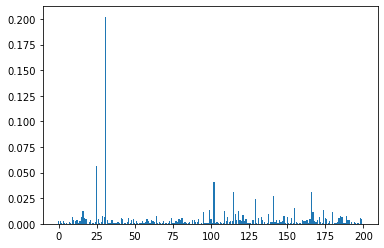

Inserting the NN (74957089) (13-th k-NN) for 22422528 at the 36-th position
Predicted 5 closest objects: [  7  40  29 191  54], p=[0.03304271 0.02329261 0.02192644 0.02133557 0.01924673]


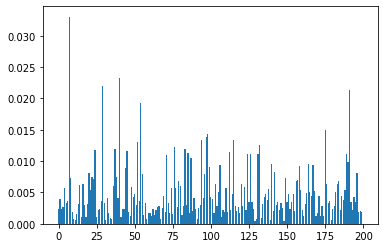

Inserting the NN (7068303) (28-th k-NN) for 99267317 at the 188-th position
Predicted 5 closest objects: [ 76 162  40  39  94], p=[0.03347683 0.02696182 0.02387608 0.02351612 0.01894515]


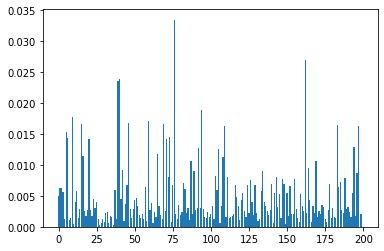

Inserting the NN (101384205) (1-th k-NN) for 14366673 at the 167-th position
Predicted 5 closest objects: [ 86 167 169 156  79], p=[0.11560945 0.08611474 0.07832847 0.06596183 0.05475171]


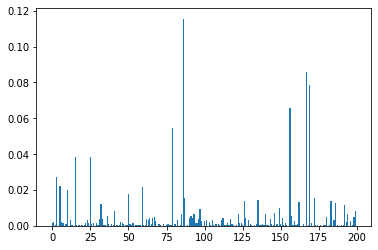

Inserting the NN (44706558) (25-th k-NN) for 54176025 at the 135-th position
Predicted 5 closest objects: [ 24 150 172 176  70], p=[0.31992686 0.07400402 0.07214075 0.07102743 0.04555715]


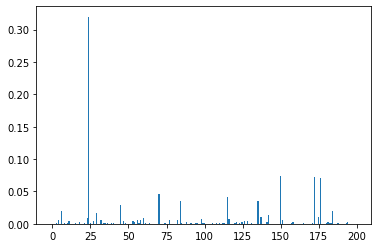

Inserting the NN (90203341) (1-th k-NN) for 64283979 at the 133-th position
Predicted 5 closest objects: [197 109  66 195 136], p=[0.03607977 0.03295089 0.0260376  0.02321471 0.02168668]


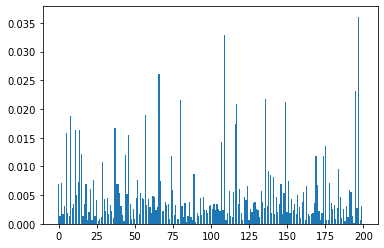

Inserting the NN (35783906) (4-th k-NN) for 9507999 at the 117-th position
Predicted 5 closest objects: [128  15 190 101 117], p=[0.0723836  0.04994288 0.04915078 0.03858992 0.03449318]


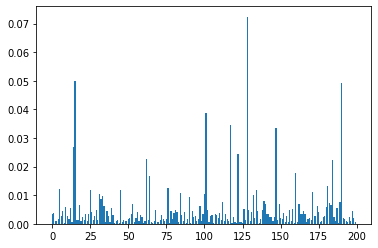

Inserting the NN (89955402) (2-th k-NN) for 46546542 at the 121-th position
Predicted 5 closest objects: [ 40  24 166  28 106], p=[0.08682897 0.04177602 0.02881036 0.02663583 0.02367987]


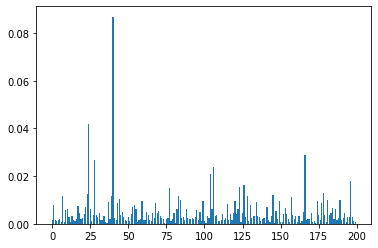

Inserting the NN (83347767) (24-th k-NN) for 40368006 at the 93-th position
Predicted 5 closest objects: [ 51 111  27 142 179], p=[0.08443785 0.02223287 0.01989109 0.01631118 0.01467622]


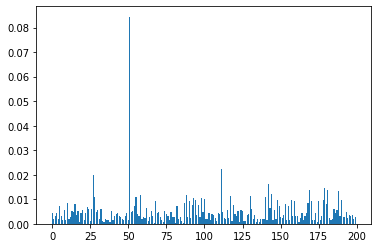

Inserting the NN (76958955) (4-th k-NN) for 90743808 at the 85-th position
Predicted 5 closest objects: [ 85  51 179  36 147], p=[0.3372853  0.06139417 0.05661536 0.03578011 0.02912915]


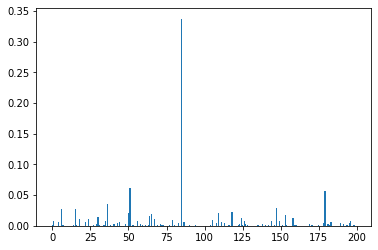

In [48]:
keys = list(knns.keys())[:10]
def pick_random_nn(key):
    rand_nn_index = random.randint(1, 29)
    #print(f'For {key}, picked out {rand_nn_index}-th nearest neighbor to look for.')
    return rand_nn_index, int(sorted(knns[key].items(), key=lambda kv: kv[1])[rand_nn_index][0])

def train_collect_preds(data, query):
    model = tf.keras.Sequential([
        layers.Dense(input_shape=[282,], units=200, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy')

    model.fit(data, np.arange(0, 200, 1), epochs=100, verbose=0)
    return model.predict(query.reshape(1, -1))

for key in keys:
    rand_cutoff = random.randint(0, 200)
    rand_nn_index, nn = pick_random_nn(key)
    data1 = descriptors.sample(rand_cutoff).values
    data2 = descriptors.sample(200 - rand_cutoff - 1).values
    print(f'Inserting the NN ({nn}) ({rand_nn_index}-th k-NN) for {key} at the {rand_cutoff}-th position')
    data_in_leaf_node = np.vstack((data1, descriptors.loc[nn].values, data2))
    preds = train_collect_preds(data_in_leaf_node, descriptors.loc[int(key)].values)
    print(f'Predicted 5 closest objects: {np.argsort(preds)[0][::-1][:5]}, p={np.sort(preds)[0][::-1][:5]}')
    plt.bar(np.arange(0, 200, 1), preds[0])
    plt.show()

## TODOs:
- build the complete LMI + examine the 'real' leaf nodes:
    - selecting `n` objects from every node (30 when doing ANN for 30-NN)
        - absolute probabilities vs. probabilities of the whole branch
        - evaluate recall (== precision on output of size 30)
    - what is the computational overhead?


- precision vs. number of objects to classify (200 vs. 2000?)
- correlation between distance function and probability distribution returned by the leaf nodes
- different datasets -- randomly generated?)

## Experiment 3 -- Correlation betw. distance function and probability distribution -- CoPhIR

In [8]:
keys = list(knns.keys())[:10]
query = keys[0]
query

'44371230'

In [18]:
def train_collect_preds(data, query):
    model = tf.keras.Sequential([
        layers.Dense(input_shape=[282,], units=30, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy')

    model.fit(data, np.arange(0, 30, 1), epochs=100, verbose=0)
    return model.predict(query.reshape(1, -1))

nns = [int(k) for k,v in list(knns[query].items())]

In [19]:
preds = train_collect_preds(descriptors.loc[nns].values, descriptors.loc[int(query)].values)

Predicted 5 closest objects: [20  0  1  4 15], p=[0.14970303 0.11850893 0.06883916 0.05589428 0.05491074]


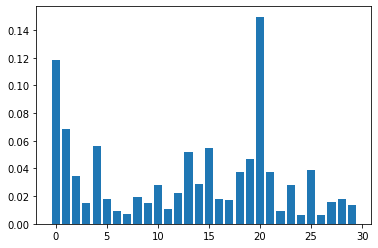

In [20]:
print(f'Predicted 5 closest objects: {np.argsort(preds)[0][::-1][:5]}, p={np.sort(preds)[0][::-1][:5]}')
plt.bar(np.arange(0, 30, 1), preds[0])
plt.show()

## Experiment 3 -- Correlation betw. distance function and probability distribution -- Profi

In [ ]:
keys = list(knns.keys())[:10]
def pick_random_nn(key):
    rand_nn_index = random.randint(1, 29)
    #print(f'For {key}, picked out {rand_nn_index}-th nearest neighbor to look for.')
    return rand_nn_index, int(sorted(knns[key].items(), key=lambda kv: kv[1])[rand_nn_index][0])

def train_collect_preds(data, query):
    model = tf.keras.Sequential([
        layers.Dense(input_shape=[282,], units=200, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy')

    model.fit(data_in_leaf_node, np.arange(0, 200, 1), epochs=100, verbose=0)
    return model.predict(query.reshape(1, -1))
"""
for key in keys:
    rand_cutoff = random.randint(0, 200)
    rand_nn_index, nn = pick_random_nn(key)
    data1 = descriptors.sample(rand_cutoff).values
    data2 = descriptors.sample(200 - rand_cutoff - 1).values
    print(f'Inserting the NN ({nn}) ({rand_nn_index}-th k-NN) for {key} at the {rand_cutoff}-th position')
    data_in_leaf_node = np.vstack((data1, descriptors.loc[nn].values, data2))
    preds = train_collect_preds(data_in_leaf_node, descriptors.loc[int(key)].values)
    print(f'Predicted 5 closest objects: {np.argsort(preds)[0][::-1][:5]}, p={np.sort(preds)[0][::-1][:5]}')
    plt.bar(np.arange(0, 200, 1), preds[0])
    plt.show()

## Regression on the reduced and sorted data

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(input_shape=[1,], units=1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

model.fit(np.array(data_leaf_node_1d_sorted), np.arange(0, 1, 1/200), epochs=1000, verbose=0)
model.predict(pca.transform([query]))

array([[0.61221725]], dtype=float32)

### Classification

In [45]:
model = tf.keras.Sequential([
    layers.Dense(input_shape=[1,], units=200, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy')

model.fit(np.array(data_leaf_node_1d_sorted), np.arange(0, 200, 1), epochs=500, verbose=0)

np.argmax(model.predict(pca.transform([query]).reshape(1, -1)))

147

## distance, sort

In [8]:
query = descriptors[0].iloc[201].values

In [53]:
def baseline_distances():
    distances = []
    obj_ids = []
    for i, obj in enumerate(descriptors[0].iloc[:200].values):
        distances.append(get_euclidean_distance(obj, query))
        obj_ids.append(i)
    return distances, obj_ids
%time dists, obj_ids = baseline_distances()

CPU times: user 3.24 ms, sys: 0 ns, total: 3.24 ms
Wall time: 3.32 ms


In [ ]:
np.aran

In [56]:
arr = np.array([dists, obj_ids, np.arange(0, 1, 1/200)]).T

In [58]:
arr[arr[:, 0].argsort()][:10]

array([[1.46374762e+01, 2.60000000e+01, 1.30000000e-01],
       [1.51930756e+01, 3.30000000e+01, 1.65000000e-01],
       [1.55172587e+01, 1.96000000e+02, 9.80000000e-01],
       [1.59540642e+01, 1.95000000e+02, 9.75000000e-01],
       [1.60311199e+01, 5.80000000e+01, 2.90000000e-01],
       [1.61789720e+01, 1.00000000e+00, 5.00000000e-03],
       [1.62447258e+01, 1.04000000e+02, 5.20000000e-01],
       [1.62895579e+01, 3.50000000e+01, 1.75000000e-01],
       [1.65867524e+01, 4.90000000e+01, 2.45000000e-01],
       [1.67126673e+01, 6.20000000e+01, 3.10000000e-01]])

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [76]:
query = descriptors[0].iloc[199].values

In [77]:
model = tf.keras.Sequential([
    layers.Dense(input_shape=[282,], units=1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error')

model.fit(descriptors[0].iloc[:200].values, np.arange(0, 1, 1/200), epochs=500, verbose=0)

model.predict(query.reshape(1, -1))

array([[0.46446785]], dtype=float32)

In [75]:
model = tf.keras.Sequential([
    layers.Dense(input_shape=[282,], units=200, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy')

model.fit(descriptors[0].iloc[:200].values, np.arange(0, 200, 1), epochs=1000, verbose=0)

np.argmax(model.predict(query.reshape(1, -1)))

KeyboardInterrupt: 

In [7]:
model_config = load_model_config(
    config['LMI']['model-config']
)

In [8]:
from lmi.indexes.LearnedMetricIndex import LMI
lmi = LMI(config['LMI'], descriptors, labels)
lmi.train(model_config)

NameError: name 'descriptors' is not defined

In [9]:
from lmi.indexes.Mindex import Mindex
from lmi.indexes.Mtree import Mtree
pivots = loader.load_mtree_pivots()
index = Mtree(descriptors, labels, pivots, config['data']['dataset'])
# or, in case of m-index:
pivots = loader.load_mindex_pivots()
index = Mindex(descriptors, labels, pivots, config['data']['dataset'])

NameError: name 'descriptors' is not defined

In [5]:
loader = ProfisetDataLoader(config)
#%time df = loader.load_descriptors()
#%time label = loader.load_tiny_labels()
#labels.head(2)

In [6]:
qs = loader.get_queries()

In [6]:
exp_dirs = [f for f in os.listdir('outputs/')]

In [10]:
to_load  = [f'outputs/{exp_dir}/times.csv' for exp_dir in exp_dirs]

In [8]:
from pathlib import Path

In [9]:
import numpy as np
import pandas as pd
index = []
for l in to_load:
    #print(np.unique(pd.read_csv(l)['query']))
    if Path.is_file(Path(l)):
        index.extend(np.unique(pd.read_csv(l)['query']))
        
    #else:
    #    print(l)

outputs/10perc-Mtree10percboxplots.png/search.csv
outputs/table-1.html/search.csv
outputs/Mocaptime-recall-stopcond-recall.png/search.csv
outputs/Profiset-1M-GMMtime-recall-stopcond-recall.png/search.csv
outputs/CoPhIR-1M-Mindex-200time-recall-stopcond-recall.png/search.csv
outputs/.ipynb_checkpoints/search.csv
outputs/CoPhIR-1M-GMMtime-recall-stopcond-recall.png/search.csv
outputs/10perc-Mindex10percboxplots.png/search.csv
outputs/Profiset-1M-Mindex-2000time-recall-stopcond-recall.png/search.csv
outputs/table-3.html/search.csv
outputs/Profiset-1M-Mtree-200time-recall-stopcond-recall.png/search.csv
outputs/CoPhIR-1M-Mindex-2000time-recall-stopcond-recall.png/search.csv
outputs/ood-MtreeOODboxplots.png/search.csv
outputs/ood-MindexOODboxplots.png/search.csv
outputs/Profiset-1M-Mtree-2000time-recall-stopcond-recall.png/search.csv
outputs/Profiset-1M-Mindex-200time-recall-stopcond-recall.png/search.csv
outputs/CoPhIR-1M-Mtree-2000time-recall-stopcond-recall.png/search.csv
outputs/report-t

In [11]:
import numpy as np

In [12]:
np.unique(index).shape[0]

1000

In [17]:
index[:4]

[101252, 101740, 102030, 102045]

In [11]:
complete_search = []
for l in to_load:
    #print(np.unique(pd.read_csv(l)['query']))
    if Path.is_file(Path(l)):
        complete_search.append(pd.read_csv(l))
    else:
        print(l)

outputs/10perc-Mtree10percboxplots.png/times.csv
outputs/table-1.html/times.csv
outputs/Mocaptime-recall-stopcond-recall.png/times.csv
outputs/Profiset-1M-GMMtime-recall-stopcond-recall.png/times.csv
outputs/CoPhIR-1M-Mindex-200time-recall-stopcond-recall.png/times.csv
outputs/.ipynb_checkpoints/times.csv
outputs/CoPhIR-1M-GMMtime-recall-stopcond-recall.png/times.csv
outputs/10perc-Mindex10percboxplots.png/times.csv
outputs/Profiset-1M-Mindex-2000time-recall-stopcond-recall.png/times.csv
outputs/table-3.html/times.csv
outputs/Profiset-1M-Mtree-200time-recall-stopcond-recall.png/times.csv
outputs/CoPhIR-1M-Mindex-2000time-recall-stopcond-recall.png/times.csv
outputs/ood-MtreeOODboxplots.png/times.csv
outputs/ood-MindexOODboxplots.png/times.csv
outputs/Profiset-1M-Mtree-2000time-recall-stopcond-recall.png/times.csv
outputs/Profiset-1M-Mindex-200time-recall-stopcond-recall.png/times.csv
outputs/CoPhIR-1M-Mtree-2000time-recall-stopcond-recall.png/times.csv
outputs/report-template.html/time

In [12]:
complete_search_pd = pd.concat(complete_search)

In [13]:
complete_search_pd.head()

,loading,training,execution
0,0.006934,2773.303422,17986.760413
0,7.412539,9707.200397,10838.198285
0,0.000297,333.548865,3248.198048
0,2.585061,30198.850113,33394.468981
0,0.000191,NaN,21730.247629


In [14]:
complete_search_pd = complete_search_pd.fillna(0)

In [20]:
final_time = sum(complete_search_pd['loading']) + sum(complete_search_pd[' training']) + sum(complete_search_pd[' execution'])

In [21]:
final_time / 60 / 60

1763.3474936219056

In [17]:
complete_search_pd.columns

Index(['loading', ' training', ' execution'], dtype='object')

In [18]:
sum(complete_search_pd[' training'])

1309747.3789598942

In [19]:
sum(complete_search_pd[' execution'])

5000322.3265480995

In [17]:
complete_search_pd.drop_duplicates(['query', 'condition']).shape

(10000, 5)

In [16]:
complete_search_pd.shape

(21860, 5)

In [18]:
complete_search_pd.drop_duplicates(['query', 'condition']).to_csv('/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs/Profiset-1M-Mtree-200-LR---2022-05-18--09-26-37/search.csv', index=None)

In [19]:
from lmi.Experiment import generate_summary

In [20]:
generate_summary('outputs/Profiset-1M-Mtree-200-LR---2022-05-18--09-26-37')

In [45]:
import pickle
with open('lr-found.pkl', 'wb') as f:
    pickle.dump(index, f)

In [37]:
rest = [q for q in qs.index.tolist() if q not in index]

In [39]:
len(rest)

236

In [42]:
pd.DataFrame(index=pd.Index(rest))

""
21657
22066
22342
22546
22979
...
97278
97424
97537
98420


In [32]:
qs

""
112
168
260
388
578
...
700460
700556
700677
700776


In [14]:
qs[qs == 358818334]

""
296166
551155
557192
565691
597668
...
101605044
101658970
101683448
101746868


In [28]:
qs.index.tolist().index(358818334)

599

In [27]:
qs.loc[358818334, :]

0     -1.291154
1     -0.259240
2      0.100218
3     -1.451330
4     -0.005996
         ...   
277    0.163802
278    0.204455
279    0.203442
280   -1.516042
281   -1.211632
Name: 358818334, Length: 282, dtype: float64

In [5]:
labels = loader.load_labels()

In [6]:
df = loader.load_descriptors()

[2022-05-22 08:32:29,303][INFO ][lmi.data.DataLoader] Loading CoPhIR dataset from /storage/brno12-cerit/home/tslaninakova/data/datasets/CoPhIR1M-descriptors.csv.


In [7]:
labels.head()

,L1_labels,L2_labels,L3_labels,L4_labels,L5_labels,L6_labels
object_id,,,,,,
337981,"[56, 56, 56, 61, 20, 56, 68, 104, 56, 20, 61, ...","[24, 8, 8, 17, 31, 56, 53, 17, 56, 60, 17, 8, ...","[150, 16, 16, 6, 150, 150, 150, 150, 150, 150,...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
549406,"[17, 111, 111, 90, 17, 111, 26, 17, 90, 17, 26...","[17, 5, 17, 16, 57, 43, 36, 33, 16, 57, 51, 43...","[150, 7, 150, 150, 150, 150, 40, 150, 150, 150...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
509874,"[26, 72, 26, 63, 63, 63, 63, 26, 63, 90, 26, 2...","[42, 36, 64, 8, 16, 16, 75, 51, 45, 48, 36, 64...","[150, 150, 2, 150, 3, 55, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
589159,"[77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 7...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 40, 8,...","[10, 10, 27, 44, 10, 34, 10, 44, 44, 10, 44, 1...","[150, 150, 150, 18, 150, 150, 150, 18, 22, 150...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
421785,"[77, 61, 108, 108, 17, 77, 90, 77, 108, 108, 1...","[58, 51, 71, 71, 45, 43, 87, 8, 71, 71, 71, 71...","[150, 150, 150, 150, 150, 150, 150, 36, 150, 1...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."


In [18]:
index = LMI(config['LMI'], df[1][:10_000], labels[:10_000])
model_config = load_model_config(config['LMI']['model-config'], index.n_levels)

In [9]:
index.labels

['L1_labels', 'L2_labels', 'L3_labels', 'L4_labels', 'L5_labels', 'L6_labels']

In [14]:
labels[:10].head()

,L1_labels,L2_labels,L3_labels,L4_labels,L5_labels,L6_labels
object_id,,,,,,
337981,"[56, 56, 56, 61, 20, 56, 68, 104, 56, 20, 61, ...","[24, 8, 8, 17, 31, 56, 53, 17, 56, 60, 17, 8, ...","[150, 16, 16, 6, 150, 150, 150, 150, 150, 150,...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
549406,"[17, 111, 111, 90, 17, 111, 26, 17, 90, 17, 26...","[17, 5, 17, 16, 57, 43, 36, 33, 16, 57, 51, 43...","[150, 7, 150, 150, 150, 150, 40, 150, 150, 150...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
509874,"[26, 72, 26, 63, 63, 63, 63, 26, 63, 90, 26, 2...","[42, 36, 64, 8, 16, 16, 75, 51, 45, 48, 36, 64...","[150, 150, 2, 150, 3, 55, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
589159,"[77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 7...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 40, 8,...","[10, 10, 27, 44, 10, 34, 10, 44, 44, 10, 44, 1...","[150, 150, 150, 18, 150, 150, 150, 18, 22, 150...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."
421785,"[77, 61, 108, 108, 17, 77, 90, 77, 108, 108, 1...","[58, 51, 71, 71, 45, 43, 87, 8, 71, 71, 71, 71...","[150, 150, 150, 150, 150, 150, 150, 36, 150, 1...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ..."


In [ ]:
index.train(model_config)

[2022-05-22 08:41:57,582][INFO ][lmi.indexes.BaseInde] Training model M.0 (root) on dataset(10000, 282) with {'model': 'MultilabelNN', 'epochs': 20, 'learning_rate': 0.0001, 'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'hidden_layers': {'dense': [{'units': 282, 'activation': 'relu', 'dropout': None}, {'units': 1024, 'activation': 'relu', 'dropout': None}, {'units': 256, 'activation': 'relu', 'dropout': None}]}}.
[2022-05-22 08:43:19,061][INFO ][lmi.indexes.BaseInde] Training level 1 with {'model': 'MultilabelNN', 'epochs': 5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'hidden_layers': {'dense': [{'units': 282, 'activation': 'relu', 'dropout': None}, {'units': 1024, 'activation': 'relu', 'dropout': None}, {'units': 256, 'activation': 'relu', 'dropout': None}]}}.
[2022-05-22 08:44:46,078][INFO ][lmi.indexes.BaseInde] Training level 2 with {'model': 'MultilabelNN', 'epochs': 5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'loss': 'catego

In [ ]:
df_tiny.index.name='object-id'

In [ ]:
df_tiny.head(10).to_csv('test-data/CoPhIR-top.csv')

In [138]:
import pandas as pd
df = pd.read_csv(f"test-data/{config_file.split('/')[-1].split('.')[0]}.csv", index_col='object-id')

In [136]:
df[~df.duplicated()].to_csv(f"test-data/{config_file.split('/')[-1].split('.')[0]}.csv")

In [123]:
f"test-data/{config_file.split('/')[-1].split('.')[0]}.csv"

'test-data/CoPhIR-1M-Mtree-200-Mtree.csv'

In [139]:
df[df.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
object-id,,,,,,,,,,,,,,,,,,,,,


In [62]:
labels = loader.load_labels()

In [41]:
labels = label#.head()

In [63]:
for level, level_label in enumerate(labels[1:], start=1):
    print(f"Training level {level}.")

Training level 1.
Training level 2.
Training level 3.
Training level 4.
Training level 5.


In [ ]:
self.labels = self.labels[:len(list(model_config.keys()))]

In [64]:
index = LMI(config['LMI'], df[0], labels)

In [65]:
index.n_levels

5

In [66]:
index.labels

['L1', 'L2', 'L3', 'L4', 'L5']

In [71]:
import yaml

In [72]:
def load_yaml(path):
    with open(path, 'r') as stream:
        loaded = yaml.safe_load(stream)
    return loaded


In [ ]:
def cut_correct_n_levels(model_config):
    for k in list(model_config.keys()):
        if k != 'model' and int(k.split('level-')[1]) >= n_levels:
            del model_config[k]
    return model_config

model_config = load_yaml(model_config_path)
model_config = cut_correct_n_levels(model_config)
return model_config

In [ ]:
int(k.split('level-')[1])

In [74]:
list(model_config.keys())

['level-0', 'level-1', 'level-2', 'level-3', 'level-4', 'level-5']

In [73]:
model_config = load_yaml(config['LMI']['model-config'])
model_config

{'level-0': {'epochs': 15,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 282},
    {'activation': 'relu', 'dropout': None, 'units': 128}]},
  'learning_rate': 0.0001,
  'loss': 'sparse_categorical_crossentropy',
  'model': 'NN',
  'optimizer': 'adam'},
 'level-1': {'epochs': 5,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 100,
     'regularizer': True}]},
  'learning_rate': 0.0001,
  'loss': 'sparse_categorical_crossentropy',
  'model': 'NN',
  'optimizer': 'adam'},
 'level-2': {'epochs': 1,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 100,
     'regularizer': True}]},
  'learning_rate': 0.0001,
  'loss': 'sparse_categorical_crossentropy',
  'model': 'NN',
  'optimizer': 'adam'},
 'level-3': {'epochs': 1,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 100,
     'regularizer': True}]},
  'learning_rate': 0.0001,
  'l

In [67]:
model_config = load_model_config(config['LMI']['model-config'], index.n_levels)

In [68]:
model_config

{'level-0': {'epochs': 15,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 282},
    {'activation': 'relu', 'dropout': None, 'units': 128}]},
  'learning_rate': 0.0001,
  'loss': 'sparse_categorical_crossentropy',
  'model': 'NN',
  'optimizer': 'adam'},
 'level-1': {'epochs': 5,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 100,
     'regularizer': True}]},
  'learning_rate': 0.0001,
  'loss': 'sparse_categorical_crossentropy',
  'model': 'NN',
  'optimizer': 'adam'},
 'level-2': {'epochs': 1,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 100,
     'regularizer': True}]},
  'learning_rate': 0.0001,
  'loss': 'sparse_categorical_crossentropy',
  'model': 'NN',
  'optimizer': 'adam'},
 'level-3': {'epochs': 1,
  'hidden_layers': {'dense': [{'activation': 'relu',
     'dropout': None,
     'units': 100,
     'regularizer': True}]},
  'learning_rate': 0.0001,
  'l

In [48]:
for level, level_label in enumerate(index.labels[1:], start=1):
    print(f"Training level {level}.")

Training level 1.
Training level 2.
Training level 3.
Training level 4.
Training level 5.


In [49]:
model_config

{'level-0': {'max_iter': 10, 'C': 10000, 'model': 'LogReg'},
 'level-1': {'max_iter': 10, 'C': 10000, 'model': 'LogReg'},
 'level-2': {'max_iter': 5, 'C': 10000, 'model': 'LogReg'},
 'level-3': {'max_iter': 5, 'C': 10000, 'model': 'LogReg'},
 'level-4': {'max_iter': 5, 'C': 10000, 'model': 'LogReg'},
 'level-5': {'max_iter': 5, 'C': 10000, 'model': 'LogReg'}}

In [141]:
pivot_df = loader.load_mtree_pivots()
#test_df = df.loc[pivot_df.index]

In [55]:
from lmi.indexes.Mtree import Mtree

In [24]:
pivot_df.index

UInt64Index([ 13622840,  27736222,  33248999,  53697048,  56724598,  69278982,
              86429386,  99726156, 102389473, 105401170,
             ...
             217338447, 220810653, 225140625, 231319789, 234882080, 240178964,
             246974267, 251479043, 255059157, 261321009],
            dtype='uint64', length=128)

ERROR! Session/line number was not unique in database. History logging moved to new session 1592


In [91]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
object-id,,,,,,,,,,,,,,,,,,,,,
3014089,13,2,18,7,14,11,32,16,16,30,...,3,0,0,0,0,-2,1,0,-3,-3
1351751,8,20,14,8,15,7,30,16,14,30,...,4,1,0,0,0,-2,1,0,-3,-3
2146226,26,13,28,19,16,14,30,18,18,28,...,3,-2,-1,0,0,-2,-1,0,-3,-3
1204650,27,19,8,11,18,3,29,16,18,31,...,6,5,-4,0,0,-2,1,0,-3,-3
3014089,13,2,18,7,14,11,32,16,16,30,...,3,0,0,0,0,-2,1,0,-3,-3


In [93]:
pivot_df.head()

,node,radius,level
3014089,"(1,)",5.708939,1
1351751,"(1, 1)",2.974208,2
2146226,"(1, 2)",3.037122,2
1204650,"(1, 3)",2.702235,2
3014089,"(1, 4)",2.903821,2


In [142]:
index = Mtree(df[:10], label.loc[df.index[:10]], pivot_df[:10], config['data']['dataset'])

In [18]:
label.head(10)

,L1,L2,L3,L4,L5,L6,L7,L8
object_id,,,,,,,,
296166,71,57,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
312568,48,76,67,<NA>,<NA>,<NA>,<NA>,<NA>
320479,19,52,124,118,<NA>,<NA>,<NA>,<NA>
325836,15,1,6,8,60,48,<NA>,<NA>
325837,8,6,15,1,54,<NA>,<NA>,<NA>
325863,6,1,8,15,85,54,<NA>,<NA>
325865,8,6,15,1,85,75,54,<NA>
325868,6,15,1,8,54,<NA>,<NA>,<NA>
325887,8,6,1,15,85,75,86,<NA>


In [62]:
pivot_df

,node,radius,level,L1,L2,L3,L4,L5,L6,L7,L8
3598306,"(1,)",7.326086,1,1,-1,-1,-1,-1,-1,-1,-1
17905614,"(1, 1)",4.645504,2,1,1,-1,-1,-1,-1,-1,-1
36053014,"(1, 1, 1)",2.314067,3,1,1,1,-1,-1,-1,-1,-1
36470959,"(1, 1, 2)",2.228175,3,1,1,2,-1,-1,-1,-1,-1
17361540,"(1, 1, 3)",2.670025,3,1,1,3,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
182181629,"(10, 25, 28)",1.910718,3,10,25,28,-1,-1,-1,-1,-1
11573747,"(10, 25, 29)",2.369734,3,10,25,29,-1,-1,-1,-1,-1
156698653,"(10, 25, 30)",1.640172,3,10,25,30,-1,-1,-1,-1,-1
116302410,"(10, 25, 31)",2.511228,3,10,25,31,-1,-1,-1,-1,-1


In [143]:
index.search(df.iloc[0], [0, 1, 2, 3, 5])

([[(1, 5)],
  [(1, 5)],
  [(1, 5), (1, 1)],
  [(1, 5), (1, 1), (1, 8)],
  [(1, 5), (1, 1), (1, 8), (1, 3), (1, 9)]],
 [0.01453089714050293,
  0.014575958251953125,
  0.01754140853881836,
  0.020561933517456055,
  0.0262606143951416],
 [1, 1, 2, 3, 5])

In [76]:
test_df = df[0].loc[pivot_df.index]
test_df.shape

(1142, 282)

In [77]:
test_df.index.name='object-id'

In [69]:
config_file.split('/')[-1].split('.')[0]

'CoPhIR-1M-Mtree-200-Mtree'

In [78]:
test_df.to_csv(f"test-data/{config_file.split('/')[-1].split('.')[0]}.csv")

In [63]:
pivot_df[pivot_df['node'].map(len) == 1]

,node,radius,level,L1,L2,L3,L4,L5,L6
3014089,"(1,)",5.708939,1,1,-1,-1,-1,-1,-1
3478864,"(2,)",5.730899,1,2,-1,-1,-1,-1,-1
1688229,"(3,)",5.530395,1,3,-1,-1,-1,-1,-1
5078273,"(4,)",5.772471,1,4,-1,-1,-1,-1,-1
3623950,"(5,)",5.864301,1,5,-1,-1,-1,-1,-1
30357199,"(6,)",5.350940,1,6,-1,-1,-1,-1,-1
20611571,"(7,)",5.161635,1,7,-1,-1,-1,-1,-1
60626724,"(8,)",5.196339,1,8,-1,-1,-1,-1,-1
577663,"(9,)",5.373545,1,9,-1,-1,-1,-1,-1
55766401,"(10,)",5.431057,1,10,-1,-1,-1,-1,-1


In [73]:
pivot_df.head()

,node,radius,level,L1,L2,L3,L4,L5,L6
3014089,"(1,)",5.708939,1,1,-1,-1,-1,-1,-1
1351751,"(1, 1)",2.974208,2,1,1,-1,-1,-1,-1
2146226,"(1, 2)",3.037122,2,1,2,-1,-1,-1,-1
1204650,"(1, 3)",2.702235,2,1,3,-1,-1,-1,-1
3014089,"(1, 4)",2.903821,2,1,4,-1,-1,-1,-1


In [70]:
df_20 = pd.concat([df[0], df[0]])
df_20.shape

(20, 282)

In [67]:
lvl_1_index = pivot_df[pivot_df['node'].map(len) == 1]

In [76]:
lvl_1_index.index

Int64Index([ 3014089,  3478864,  1688229,  5078273,  3623950, 30357199,
            20611571, 60626724,   577663, 55766401,  1794063,  3128543,
            61865786,  2360262,  1851684, 13238797,  2360297, 16193358],
           dtype='int64')

In [77]:
len(lvl_1_index.index)

18

In [79]:
df_20.index = lvl_1_index.index.tolist() + [1351751, 2146226]

In [81]:
df_20.tail()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
13238797,57,17,25,12,15,16,29,17,18,34,...,10,5,0,0,0,-2,1,0,-3,-6
2360297,56,24,17,27,13,25,27,18,16,44,...,7,7,-1,0,0,-2,1,0,-3,3
16193358,56,13,22,17,17,28,31,16,17,43,...,13,13,0,0,0,-2,1,0,-3,-9
1351751,56,14,14,28,16,15,30,16,16,24,...,9,4,0,0,0,-4,1,0,-3,-3
2146226,59,16,16,16,16,16,30,16,16,35,...,8,6,0,0,0,-2,1,0,-3,2


In [64]:
df[:len(pivot_df[pivot_df['node'].map(len) == 1])].reindex(pivot_df[pivot_df['node'].map(len) == 1].index)

AttributeError: 'tuple' object has no attribute 'reindex'

In [54]:
df_20.to_csv('test-data/CoPhIR-1M-MTREE-2000.csv', index=None)

In [14]:
pivot_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
240178964,43,16,22,23,10,23,30,16,20,31,...,2,-5,0,0,0,-2,1,0,-3,-3
246974267,15,4,15,11,10,8,27,14,14,37,...,1,-4,0,0,0,-2,1,0,-3,-3
251479043,53,11,26,25,20,14,24,13,20,30,...,4,2,-1,-10,0,-2,1,0,-3,-3
255059157,15,12,31,27,18,11,37,16,17,30,...,12,8,-1,0,0,-2,-4,0,-3,-5
261321009,20,13,12,8,8,25,20,19,14,43,...,3,1,-6,-5,0,-2,1,0,-3,-4


In [48]:
config

{'LMI': {'model-config': '', 'training-dataset-percentage': 1},
 'data': {'data-dir': '/storage/brno12-cerit/home/tslaninakova/data/',
  'dataset': 'COPHIR',
  'dataset-size': '1M',
  'normalize': False,
  'original': {'index': 'MTREE', 'leaf-node-capacity': 2000},
  'shuffle': True,
  'shuffle-seed': 1},
 'experiment': {'gt-subdir': 'ground-truths',
  'knns': 30,
  'output-dir': 'outputs',
  'queries-out-of-dataset': False,
  'search-stop-conditions': [0.0005,
   0.001,
   0.003,
   0.005,
   0.01,
   0.05,
   0.1,
   0.2,
   0.3,
   0.5]},
 'setup': 'exp-basic'}

In [7]:
label = loader.load_labels()

In [ ]:
label = loader.load_labels_tiny()

In [8]:
pivot_df = loader.load_mindex_pivots()

[2022-05-18 11:03:46,730][INFO ][lmi.data.DataLoader] Loading CoPhIR dataset from /storage/brno12-cerit/home/tslaninakova/data//pivots/MIndex-CoPhIR-1M-descriptors.csv.


In [26]:
from lmi.indexes.Mtree import Mtree

In [32]:
pivot_df = loader.load_mtree_pivots()

In [57]:
df = pd.read_csv('test-data/CoPhIR-1M-MTREE-2000.csv', index_col='id')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
id,,,,,,,,,,,,,,,,,,,,,
3014089,56,16,20,16,17,14,28,16,18,34,...,6,7,-2,0,0,-2,1,0,-3,-5
1351751,51,19,24,21,17,19,35,14,15,31,...,8,4,0,0,0,-2,1,0,-3,-3


In [82]:
#primary_descriptors = df[0]# if config['data']['dataset'] == 'COPHIR' else df
index = Mtree(df_20, label[:20], pivot_df, config['data']['dataset'])
mem_train = 0

In [37]:
pivot_df.head()

,node,radius,level,L1,L2,L3,L4,L5,L6
3014089,"(1,)",5.708939,1,1,-1,-1,-1,-1,-1
1351751,"(1, 1)",2.974208,2,1,1,-1,-1,-1,-1
2146226,"(1, 2)",3.037122,2,1,2,-1,-1,-1,-1
1204650,"(1, 3)",2.702235,2,1,3,-1,-1,-1,-1
3014089,"(1, 4)",2.903821,2,1,4,-1,-1,-1,-1


In [38]:
%ls /storage/brno12-cerit/home/tslaninakova/data/datasets

CoPhIR100k-descriptors.csv*    Profiset100k-objects.txt*
CoPhIR100k-objects.txt*        Profiset1M-descriptors.csv*
CoPhIR1M-descriptors.csv*      Profiset1M-objects.txt*
CoPhIR1M-objects.txt*          descriptors_10.pd
MoCap-descriptors.csv          protein-chains-100k.pd
MoCap-objects.txt              protein-chains-500k.pd
Profiset100k-descriptors.csv*


In [ ]:
import pandas as pd
import numpy as np
%time df_orig = pd.read_csv('/storage/brno12-cerit/home/tslaninakova/data/datase', header=None,sep=r'[,|;]', engine='python', dtype=np.int32,skiprows=lambda x: x not in [3014089, 1351751],usecols=[i for i in range(284) if i != 218 and i != 219])

In [36]:
pivot_df.shape

(1142, 9)

In [ ]:
children_df = self.pivots_df.query(get_children_selection(node_label))

In [85]:
pivot_df.loc[1204650]

node       (1, 3)
radius    2.70223
level           2
L1              1
L2              3
L3             -1
L4             -1
L5             -1
L6             -1
Name: 1204650, dtype: object

In [84]:
index.search(df_20.iloc[0].name, [1])

Exception: Object with id 1204650 does not exist in the trained dataset.

In [17]:
loader = CoPhIRDataLoader(config)
%time labels_mtree = loader.load_labels()
labels_mtree.head(2)

CPU times: user 14.2 s, sys: 659 ms, total: 14.9 s
Wall time: 15.7 s


,L1,L2,L3
object_id,,,
296166,3,13,7
312568,4,17,8


In [46]:
import json
with open('/storage/brno12-cerit/home/tslaninakova/data/ground-truths/CoPhIR-1k-for-1M-dataset.json', 'rb') as f:
    knns = json.load(f)

In [8]:
list(knns.keys())[0]

'36126726'

In [16]:
labels_mindex.columns

Index(['L1', 'L2', 'L3', 'L4', 'L5', 'L6'], dtype='object')

In [21]:
import pandas as pd
import numpy as np

In [27]:
pd.isnull(labels_mindex.loc[int(k)]['L4'])

True

In [30]:
p = '115_34_41_'
p[:-1]

'115_34_41'

In [48]:
list(knns[k].keys())[0]

'291838467'

In [54]:
query = '36126726'

In [57]:
def get_unique_placements(labels):
    unique_placements = []
    for k in list(knns.keys()):
        placements = []
        for neighbor in list(knns[k].keys()):
            placement = ""
            for column in labels.columns:
                if not pd.isnull(labels.loc[int(neighbor)][column]):
                    placement += str(labels.loc[int(neighbor)][column]) + '_'
            placements.append(placement[:-1])
        unique_placements.append(np.unique(placements).shape[0])
    return unique_placements

In [36]:
unique_placements[:10]

[18, 17, 13, 22, 8, 27, 23, 14, 14, 23]

In [58]:
unique_placements_mtree = get_unique_placements(labels_mtree)
unique_placements_mtree[:10]

[28, 30, 22, 24, 24, 27, 23, 22, 24, 29]

Text(0.5, 1.0, 'Dispersion of 30-NNs, M-tree (3-lvl) vs. M-index (6-lvl)')

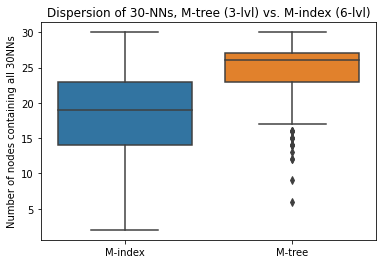

In [60]:
import seaborn as sns

bp = sns.boxplot(
    data=pd.DataFrame(
        {'M-index': unique_placements, 'M-tree': unique_placements_mtree}
    )
)
bp.set_ylabel('Number of nodes containing all 30NNs')
bp.set_title('Dispersion of 30-NNs, M-tree (3-lvl) vs. M-index (6-lvl)')

In [ ]:
import numpy as np

def get_nn_placement(ref_df, col):
    n_classes_all = []
    for k in list(knns.keys()):
        query_obj = ref_df.loc[int(k)]
        #print(f"query_obj: {query_obj['y_pred_root']}")
        n_classes = []
        for neighbor in list(knns[k].keys()):
            neighbor = ref_df.loc[int(neighbor)]
            #print(f"    neigh_obj: {neighbor['y_pred_root']}")
            n_classes.append(neighbor[col])
        n_classes_all.append(np.unique(n_classes).shape[0])
    return n_classes_all

In [5]:
%time data = loader.load_descriptors()

[2022-04-24 10:49:57,667][INFO ][lmi.data.DataLoader] Loading Profiset/MoCap dataset from /storage/brno12-cerit/home/tslaninakova/data/datasets/MoCap-descriptors.csv.


CPU times: user 12min 18s, sys: 41.4 s, total: 12min 59s
Wall time: 12min 59s


In [7]:
from lmi.utils import intersect_mocap_dataset

In [10]:
df_new, labels_new = intersect_mocap_dataset(data, labels)

In [11]:
df_new.shape, labels_new.shape

((353902, 4096), (353902, 2))

In [61]:
import pandas as pd
objects = pd.read_csv('/storage/brno12-cerit/home/tslaninakova/data/datasets/CoPhIR1M-objects.txt', header=None)

In [7]:
objects.head()

,0
0,337981
1,549406
2,509874
3,589159
4,421785


In [8]:
labels = labels.reindex(objects[0])

In [9]:
labels.head()

,L1,L2
0,,
337981,5,6
549406,5,6
509874,5,6
589159,5,6
421785,5,6


In [10]:
labels.sort_index()

,L1,L2
0,,
296166,3,11
312568,15,7
320479,13,60
325836,1,8
325837,1,28
...,...,...
543984434,16,32
543984436,1,53
543987212,16,84


In [7]:
labels.set_index(objects[0])["L1"]

0
337981        3
549406       15
509874       13
589159        1
421785        1
             ..
541533206    16
542068518     1
542156527    16
542844034    13
543578897    16
Name: L1, Length: 1000000, dtype: uint32

In [11]:
labels.reindex(objects[0])["L1"]

0
337981       5
549406       5
509874       5
589159       5
421785       5
            ..
541533206    2
542068518    2
542156527    2
542844034    2
543578897    2
Name: L1, Length: 1000000, dtype: uint32

In [64]:
labels_mindex[(labels_mindex['L1'] == 71) & (labels_mindex['L2'] == 57)]

,L1,L2,L3,L4,L5,L6
object_id,,,,,,
296166,71,57,<NA>,<NA>,<NA>,<NA>
14446948,71,57,<NA>,<NA>,<NA>,<NA>
25880037,71,57,<NA>,<NA>,<NA>,<NA>
25881366,71,57,<NA>,<NA>,<NA>,<NA>
25883336,71,57,<NA>,<NA>,<NA>,<NA>
29287111,71,57,<NA>,<NA>,<NA>,<NA>
39110534,71,57,<NA>,<NA>,<NA>,<NA>
65549305,71,57,<NA>,<NA>,<NA>,<NA>
100537236,71,57,<NA>,<NA>,<NA>,<NA>


In [62]:
labels_mindex.reindex(objects[0]).to_csv('/storage/brno2/home/tslaninakova/CoPhIR1M-Mindex-2000-labels.csv', index=None, header=None)

In [36]:
loader = CoPhIRDataLoader(config)

In [37]:
#labels = loader.load_labels()
pivot_df = loader.load_mindex_pivots()

[2022-04-07 09:04:26,848][INFO ][lmi.data.DataLoader] Loading CoPhIR dataset from /storage/brno12-cerit/home/tslaninakova/data//pivots/MIndex-CoPhIR-1M-descriptors.csv.


In [38]:
pivot_df.head()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
13622840,14,25,9,14,20,8,30,16,17,30,...,4,-1,0,0,0,-2,1,0,-3,-3
27736222,23,9,29,7,6,8,32,16,16,32,...,3,0,0,0,0,-2,1,0,-3,-3
33248999,30,11,25,16,11,11,34,16,17,31,...,1,-5,1,0,0,-2,0,0,-3,-3
53697048,16,12,21,16,14,15,30,15,17,37,...,3,1,-1,-1,0,-2,-1,0,-4,-8
56724598,28,27,17,22,20,12,26,17,11,25,...,4,1,0,-2,-1,-2,1,-1,-3,-3


In [41]:
import gc

In [39]:
del pivot_df

In [40]:
del queries

In [42]:
del dataset

In [44]:
del loader

In [45]:
gc.collect()

424

In [43]:
del labels

In [6]:
queries = loader.get_queries()

In [7]:
from lmi.distances.euclidean import get_euclidean_distance

In [10]:
dataset.shape

(10, 4096)

In [12]:
query_id = 1866289
import numpy as np
import pandas as pd

In [16]:
def get_object(object, reshape=True):
    if type(object) == np.ndarray:
        return object.reshape(1, -1)
    elif type(object) == pd.core.series.Series:
        return object.values.reshape(1, -1)
    else:
        try:
            object = dataset.loc[object, ].values
            if reshape:
                return object.reshape(1, -1)
            else:
                return object
        except KeyError:
            raise Exception(f'Object with id {object} does not exist in the trained dataset.')


In [17]:
if isinstance(query_id, (int, np.integer)) or isinstance(query_id, str):
    query = get_object(query_id, reshape=False)
else:
    try:
        query = query_id.values
    except AttributeError:
        query = query_id

In [18]:
query

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
pivot_df = loader.load_mindex_pivots()

In [25]:
pivot_df.head()

8800      0.953613
45343     0.000000
49340     0.000000
99085     0.000000
109380    0.000000
Name: 0, dtype: float16

In [31]:
for pivot_descriptor in pivot_df.values[:1]:
    print(pivot_descriptor.shape, query.shape)
    get_euclidean_distance(pivot_descriptor, query)

(4096,) (4096,)


In [39]:
dataset.drop([4096], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
1866289,0.000000,0.0,0.000000,0.235242,1.255550,3.42303,0.000000,0.000000,3.339290,0.417240,...,0.033455,0.0,0.000000,0.000000,0.000000,0.221979,4.477560,0.000000,0.000000,0.000000
1866293,0.000000,0.0,0.000000,0.344806,0.000000,2.91817,0.000000,0.000000,0.915877,0.163597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,6.231800,0.000000,0.000000,0.070055
1866296,3.634230,0.0,0.000000,0.509658,0.000000,1.98039,0.000000,0.000000,2.466790,1.082110,...,0.000000,0.0,0.071962,0.000000,0.000000,0.000000,5.170170,0.000000,0.000000,1.317610
1866292,0.155025,0.0,0.000000,0.059828,0.147860,4.27600,0.553222,0.866644,0.000000,0.000000,...,0.272011,0.0,0.305491,0.342989,0.000000,0.479859,4.178310,0.000000,0.000000,1.032310
1866291,0.000000,0.0,0.000000,0.000000,0.006650,6.83670,1.068830,1.021450,0.000000,0.000000,...,0.968732,0.0,0.029012,1.011620,0.000000,1.996660,3.041710,0.000000,0.000000,0.817380
1866294,0.395871,0.0,0.000000,0.000000,0.000000,3.96423,0.000000,0.000000,1.614150,0.235908,...,0.000000,0.0,0.000000,0.000000,0.000000,0.008648,4.613070,0.361133,0.000000,1.695850
1866290,0.000000,0.0,0.000000,0.000000,0.000000,1.15062,0.000000,0.000000,4.248710,4.868070,...,0.000000,0.0,1.198160,0.000000,0.000000,0.000000,5.540820,0.000000,0.000000,0.000000
1866295,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3.410610,3.161100,...,0.000000,0.0,2.583500,0.000000,0.000000,0.000000,4.448340,0.000000,0.000000,0.000000
1866288,2.079880,0.0,0.262393,1.409370,3.156260,0.00000,0.024265,0.000000,0.000000,0.195682,...,0.000000,0.0,0.210303,0.000000,0.041993,0.438306,0.014868,0.000000,0.101547,0.000000
1866287,0.000000,0.0,0.000000,0.000000,0.381626,1.95952,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.017320,0.000000,0.000000,0.184601


In [37]:
dataset.shape

(10, 4097)

In [ ]:
%time labels = loader.load_labels()
#labels = labels[:10]

In [9]:
labels.head()

,L1,L2,L3,L4,L5,L6,L7,L8
object_id,,,,,,,,
296166,71,57,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
312568,48,76,67,<NA>,<NA>,<NA>,<NA>,<NA>
320479,19,52,124,118,<NA>,<NA>,<NA>,<NA>
325836,15,1,6,8,60,48,<NA>,<NA>
325837,8,6,15,1,54,<NA>,<NA>,<NA>


In [55]:
from lmi.utils import intersect_mocap_dataset
df, labels = intersect_mocap_dataset(dataset, labels)

In [23]:
labels.head()

,L1,L2,L3,L4,L5,L6,L7,L8
object_id,,,,,,,,
296166,71,57,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
312568,48,76,67,<NA>,<NA>,<NA>,<NA>,<NA>
320479,19,52,124,118,<NA>,<NA>,<NA>,<NA>
325836,15,1,6,8,60,48,<NA>,<NA>
325837,8,6,15,1,54,<NA>,<NA>,<NA>


In [24]:
dataset[0].head()

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
536773645,0.079305,-0.565466,-0.106752,-0.576117,1.028992,-0.978019,-0.803399,0.088045,1.071217,0.017653,...,-0.939336,0.307148,-1.860521,0.0,0.0,0.333333,-0.333333,0.0,-0.333333,-0.534052
536640184,0.079305,1.815444,-0.907393,1.344273,-2.400980,1.467029,-1.020534,1.848947,0.139724,1.782939,...,-0.626224,0.307148,-0.620174,0.0,0.0,0.333333,-0.333333,0.0,-0.333333,1.839512
542844034,0.079305,-1.160694,-1.708034,1.518854,0.171499,-0.755742,-0.369129,0.088045,0.139724,-1.747633,...,0.000000,-0.614295,0.620174,0.0,0.0,-3.000000,-0.333333,0.0,-0.333333,0.059339
543578897,-1.903324,0.327375,0.960769,0.296788,1.028992,0.133366,0.716545,-1.672857,-0.326023,-0.511933,...,-0.313112,-0.614295,0.620174,0.0,0.0,0.333333,-0.333333,0.0,-0.333333,0.059339
536831087,0.475831,-0.267852,1.227649,-1.274441,-0.685994,-0.533465,-0.586264,0.968496,1.071217,0.017653,...,0.313112,-0.307148,0.620174,0.0,0.0,0.333333,-0.333333,0.0,-0.333333,-0.830747


In [26]:
labels[:100].shape, dataset[0].shape

((100, 8), (10, 282))

In [11]:
index = LMI(config['LMI'], dataset[0], labels, reindex=False)

In [12]:
model_config = load_model_config(config['LMI']['model-config'], index.n_levels)

In [14]:
labels

,L1,L2,L3,L4,L5,L6,L7,L8
object_id,,,,,,,,
296166,71,57,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
312568,48,76,67,<NA>,<NA>,<NA>,<NA>,<NA>
320479,19,52,124,118,<NA>,<NA>,<NA>,<NA>
325836,15,1,6,8,60,48,<NA>,<NA>
325837,8,6,15,1,54,<NA>,<NA>,<NA>
325863,6,1,8,15,85,54,<NA>,<NA>
325865,8,6,15,1,85,75,54,<NA>
325868,6,15,1,8,54,<NA>,<NA>,<NA>
325887,8,6,1,15,85,75,86,<NA>


In [25]:
index.pred_data

In [26]:
config

{'setup': 'exp-basic',
 'data': {'data-dir': '/storage/brno12-cerit/home/tslaninakova/data/',
  'dataset': 'COPHIR',
  'dataset-size': '1M',
  'original': {'index': 'MINDEX', 'leaf-node-capacity': 200},
  'normalize': True,
  'shuffle': True},
 'LMI': {'model-config': 'experiment-setups/basic/models/CoPhIR-1M-Mindex-200-LR-model.yml',
  'training-dataset-percentage': 1},
 'experiment': {'gt-subdir': 'ground-truths',
  'output-dir': 'outputs',
  'search-stop-conditions': [0.0005,
   0.001,
   0.003,
   0.005,
   0.01,
   0.05,
   0.1,
   0.2,
   0.3,
   0.5],
  'knns': 30,
  'queries-out-of-dataset': False}}

In [27]:
from lmi.indexes.lmi_utils import split_data

In [28]:
train_data, pred_data = split_data(
    dataset[0],
    labels,
    1
)

In [29]:
train_data.y.head()

,L1,L2,L3,L4,L5,L6,L7,L8
536831087,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
543578897,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
536773645,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
542844034,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
542156527,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [23]:
index.train_data.y.head()

,L1,L2,L3,L4,L5,L6,L7,L8
536831087,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
543578897,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
536773645,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
542844034,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
542156527,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [18]:
index.train(model_config)

[2022-03-25 14:10:51,175][INFO ][lmi.indexes.BaseInde] Training model M.0 (root) on dataset(10, 282) with {'max_iter': 10, 'C': 10000, 'model': 'LogReg'}.


[nan nan nan nan nan nan nan nan nan nan]
in LMI: [nan nan nan nan nan nan nan nan nan nan]


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [57]:
knns = loader.get_knn_ground_truth()

In [61]:
dataset.iloc[0].name

'3459_3459-1584-93_1584_93'

In [62]:
knns_ = {dataset.iloc[0].name: {dataset.iloc[0].name: 0.0}}

In [73]:
dataset.iloc[0].values.shape

(4096,)

In [76]:
from lmi.Experiment import Evaluator
evaluator = Evaluator(index, knns_, dataset.iloc[:1], config, job_id='0')

In [77]:
evaluator.run_evaluate()

[2022-03-25 13:56:04,517][INFO ][lmi.Experiment] Starting the search for 1 queries.
[2022-03-25 13:56:04,530][INFO ][lmi.Experiment] Search is finished, results are stored in: 'outputs/0/search.csv'


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_boxplots(data_a, data_b, index="M-tree"):
    ticks = [index, 'LogReg', 'RF', 'NN', 'NN Multi']

    def set_box_color(bp, color):
        for i in ['boxes', 'medians', 'caps', 'whiskers']:
            plt.setp(bp[i], color=color)
            bp[i][0].set(linewidth=2)
        for i in ['caps', 'whiskers']:
            bp[i][1].set(linewidth=2)

    fig = plt.figure(figsize=(5,3))

    #print(np.array(range(len(data_a)))*2.0-0.4)

    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.3, sym='', widths=0.5)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.3, sym='', widths=0.5)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Descriptor length: 282')
    plt.plot([], c='#2C7BB6', label='Descriptor length: 4096')
    plt.legend(prop={'size': 8}, loc="lower right")

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(-0.01, 1.05)
    plt.grid(axis='y')
    #plt.tight_layout()
    #plt.savefig('boxcompare.png')
    #plt.show()
    extent = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(f"./plots/boxplots-{index}.eps", format='eps', bbox_inches=extent.expanded(1.1, 1.1))
    
#data_a = [cophir_mtree["MI"], cophir_mtree["LR"].values, cophir_mtree["RF"].values, cophir_mtree["NN"].values, cophir_mtree["NNM"].values]
#data_b = [profi_mtree["MI"], profi_mtree["LR"].values, profi_mtree["RF"].values, profi_mtree["NN"].values, profi_mtree["NNM"].values]
#plot_boxplots(data_a, data_b)

In [2]:
from lmi.enums import Mtree10perc, Mindex10perc
import itertools

In [10]:
def get_combinations(target_enum):
    return tuple(['-'.join(p) for p in itertools.product(*[e.value for e in target_enum])])
get_combinations(Mindex10perc)

('CoPhIR-1M-Mindex-2000-LR-',
 'CoPhIR-1M-Mindex-2000-LR-10perc',
 'CoPhIR-1M-Mindex-2000-NN-',
 'CoPhIR-1M-Mindex-2000-NN-10perc',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-10perc',
 'CoPhIR-1M-Mindex-2000-RF-',
 'CoPhIR-1M-Mindex-2000-RF-10perc')

In [11]:
get_combinations(Mtree10perc)

('Profiset-1M-Mtree-200-LR-',
 'Profiset-1M-Mtree-200-LR-10perc',
 'Profiset-1M-Mtree-200-NN-',
 'Profiset-1M-Mtree-200-NN-10perc',
 'Profiset-1M-Mtree-200-multilabel-NN-',
 'Profiset-1M-Mtree-200-multilabel-NN-10perc',
 'Profiset-1M-Mtree-200-RF-',
 'Profiset-1M-Mtree-200-RF-10perc')

In [42]:
DIR = '/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs/'

In [13]:
[exp_file for exp_file in os.listdir(DIR) if exp_file in get_combinations(Mindex10perc)]

[]

In [17]:
import re
def regex_model_names(model_names):
    model_names_re = '('
    for name in model_names:
        model_names_re += f'{name}|'
    model_names_re = model_names_re[:-1]
    model_names_re += ')'
    return model_names_re

In [30]:
models = regex_model_names([c[:-1] if c.endswith('-') else c for c in get_combinations(Mindex10perc)])

In [4]:
Mindex10perc.__name__

'Mindex10perc'

In [31]:
models

'(CoPhIR-1M-Mindex-2000-LR|CoPhIR-1M-Mindex-2000-LR-10perc|CoPhIR-1M-Mindex-2000-NN|CoPhIR-1M-Mindex-2000-NN-10perc|CoPhIR-1M-Mindex-2000-multilabel-NN|CoPhIR-1M-Mindex-2000-multilabel-NN-10perc|CoPhIR-1M-Mindex-2000-RF|CoPhIR-1M-Mindex-2000-RF-10perc)'

In [24]:
combination = get_combinations(Mindex10perc)

In [130]:
combination

('CoPhIR-1M-Mindex-2000-LR-',
 'CoPhIR-1M-Mindex-2000-LR-10perc',
 'CoPhIR-1M-Mindex-2000-NN-',
 'CoPhIR-1M-Mindex-2000-NN-10perc',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-10perc',
 'CoPhIR-1M-Mindex-2000-RF-',
 'CoPhIR-1M-Mindex-2000-RF-10perc')

In [32]:
[exp_file for exp_file in os.listdir(DIR) if re.match(f'^{models}--.*$', exp_file)]

['CoPhIR-1M-Mindex-2000-RF--2022-01-05--22-21-49',
 'CoPhIR-1M-Mindex-2000-RF-10perc--2022-01-21--21-05-09',
 'CoPhIR-1M-Mindex-2000-LR--2022-01-05--19-25-27',
 'CoPhIR-1M-Mindex-2000-LR-10perc--2022-01-21--16-36-03',
 'CoPhIR-1M-Mindex-2000-multilabel-NN--2022-01-19--12-09-11',
 'CoPhIR-1M-Mindex-2000-NN-10perc--2022-01-27--09-27-47',
 'CoPhIR-1M-Mindex-2000-NN--2022-01-05--19-40-34']

In [101]:
from lmi.visualization import Plot, plot_boxplots

In [104]:
l = [exp_file for exp_file in os.listdir(DIR) if re.match(f'^{models}--.*$', exp_file)]

In [105]:
a = sorted(l, key=lambda x: x.split('-')[4], reverse=True)

In [106]:
a

['CoPhIR-1M-Mindex-2000-multilabel-NN--2022-04-23--16-51-03',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-10perc--2022-04-25--11-35-52',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-10perc--2022-04-13--07-08-27',
 'CoPhIR-1M-Mindex-2000-multilabel-NN--2022-04-18--07-48-05',
 'CoPhIR-1M-Mindex-2000-RF-10perc--2022-04-25--09-12-48',
 'CoPhIR-1M-Mindex-2000-RF--2022-04-23--21-06-41',
 'CoPhIR-1M-Mindex-2000-RF-10perc--2022-04-15--00-37-10',
 'CoPhIR-1M-Mindex-2000-RF--2022-04-17--22-36-19',
 'CoPhIR-1M-Mindex-2000-NN-10perc--2022-04-15--04-00-22',
 'CoPhIR-1M-Mindex-2000-NN--2022-04-24--01-12-35',
 'CoPhIR-1M-Mindex-2000-NN-10perc--2022-04-25--08-53-16',
 'CoPhIR-1M-Mindex-2000-NN--2022-04-17--20-23-49',
 'CoPhIR-1M-Mindex-2000-LR--2022-04-24--03-42-18',
 'CoPhIR-1M-Mindex-2000-LR-10perc--2022-04-15--14-49-16',
 'CoPhIR-1M-Mindex-2000-LR--2022-04-14--04-54-22',
 'CoPhIR-1M-Mindex-2000-LR-10perc--2022-04-25--08-23-02']

In [139]:
final_candidates = []

for comb in [f'{c}-' if c.endswith('-') else c for c in get_combinations(Mindex10perc)]:
    for a_ in a:
        if a_.startswith(comb) and not any([f.startswith(comb) for f in final_candidates]):
            final_candidates.append(a_)

In [140]:
final_candidates

['CoPhIR-1M-Mindex-2000-LR--2022-04-24--03-42-18',
 'CoPhIR-1M-Mindex-2000-LR-10perc--2022-04-15--14-49-16',
 'CoPhIR-1M-Mindex-2000-NN--2022-04-24--01-12-35',
 'CoPhIR-1M-Mindex-2000-NN-10perc--2022-04-15--04-00-22',
 'CoPhIR-1M-Mindex-2000-multilabel-NN--2022-04-23--16-51-03',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-10perc--2022-04-25--11-35-52',
 'CoPhIR-1M-Mindex-2000-RF--2022-04-23--21-06-41',
 'CoPhIR-1M-Mindex-2000-RF-10perc--2022-04-25--09-12-48']

In [156]:
ticks = [a_.split('-')[4] for a_ in final_candidates]

In [157]:
ticks

['LR', 'LR', 'NN', 'NN', 'multilabel', 'multilabel', 'RF', 'RF']

In [86]:
from lmi.enums import BasicMtree, BasicMindex, MODELS, MTREE, MINDEX, GMMMtree, GMMMindex, GMMCoPhIR, GMMProfiset

MODEL_NAMES = [f'{m}-10perc' for m in MODELS] + MODELS + MTREE + MINDEX + ['GMM']

In [87]:
def get_model_names(experiment_files):
    model_names = []
    for exp_file in experiment_files:
        for model_name in MODEL_NAMES:
            if model_name != 'NN' and model_name in exp_file or \
               model_name == 'NN' and model_name in exp_file and 'multilabel-NN' not in exp_file:
                model_names.append(model_name)
                break
    return model_names

In [150]:
test_files_a = [test_file for test_file in final_candidates if '10perc' in test_file]
test_files_b = [test_file for test_file in final_candidates if '10perc' not in test_file]

In [160]:
ticks = [a_.split('-')[4] for a_ in test_files_a]

In [151]:
import pandas as pd
scores_a = []
for t in test_files_a:
    search = pd.read_csv(f'{DIR}/{t}/search.csv')
    scores_a.append(search[search['condition'] == 50_000]['knn_score'].values)

In [152]:
scores_b = []
for t in test_files_b:
    search = pd.read_csv(f'{DIR}/{t}/search.csv')
    scores_b.append(search[search['condition'] == 50_000]['knn_score'].values)

In [89]:
get_model_names(test_files)

['LR', 'LR-10perc', 'RF', 'RF-10perc']

In [146]:
plot = Plot(
    test_files
)

In [153]:
test_files_b

['CoPhIR-1M-Mindex-2000-LR--2022-04-24--03-42-18',
 'CoPhIR-1M-Mindex-2000-NN--2022-04-24--01-12-35',
 'CoPhIR-1M-Mindex-2000-multilabel-NN--2022-04-23--16-51-03',
 'CoPhIR-1M-Mindex-2000-RF--2022-04-23--21-06-41']

In [149]:
test_files_a

['CoPhIR-1M-Mindex-2000-multilabel-NN-10perc--2022-04-25--11-35-52',
 'CoPhIR-1M-Mindex-2000-multilabel-NN-10perc--2022-04-13--07-08-27',
 'CoPhIR-1M-Mindex-2000-RF-10perc--2022-04-25--09-12-48',
 'CoPhIR-1M-Mindex-2000-RF-10perc--2022-04-15--00-37-10',
 'CoPhIR-1M-Mindex-2000-NN-10perc--2022-04-15--04-00-22',
 'CoPhIR-1M-Mindex-2000-NN-10perc--2022-04-25--08-53-16',
 'CoPhIR-1M-Mindex-2000-LR-10perc--2022-04-15--14-49-16',
 'CoPhIR-1M-Mindex-2000-LR-10perc--2022-04-25--08-23-02']

In [161]:
ticks

['LR', 'NN', 'multilabel', 'RF']

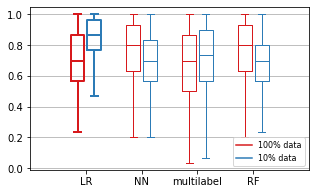

In [162]:
plot_boxplots(scores_a, scores_b, ticks, labels=['100% data', '10% data'])

In [5]:
from lmi.visualization import Plot
import os
from lmi.enums import BasicMtree, BasicMindex, Table3, IndexTable3
import itertools
from lmi.visualization import Plot
import pandas as pd
import numpy as np


OUTPUT_DIR = '../report'

def get_combinations(target_enum):
    return tuple(['-'.join(p) for p in itertools.product(*[e.value for e in target_enum])])

In [6]:
col_names = get_combinations(Table3)
index_names = get_combinations(IndexTable3)
df = pd.DataFrame(np.random.uniform(low=-1, high=0, size=(4,8)), index=index_names, columns = col_names)
print(df.columns)

Index(['CoPhIR-Mindex-2000-LR', 'CoPhIR-Mindex-2000-RF',
       'CoPhIR-Mindex-2000-NN', 'CoPhIR-Mindex-2000-multilabel-NN',
       'Profiset-Mtree-200-LR', 'Profiset-Mtree-200-RF',
       'Profiset-Mtree-200-NN', 'Profiset-Mtree-200-multilabel-NN'],
      dtype='object')


In [6]:
index_names

('build t. (h)-100%',
 'build t. (h)-10%',
 'memory (gb)-100%',
 'memory (gb)-10%')

In [7]:
df.head()

,CoPhIR-Mindex-2000-LR,CoPhIR-Mindex-2000-RF,CoPhIR-Mindex-2000-NN,CoPhIR-Mindex-2000-multilabel-NN,Profiset-Mtree-200-LR,Profiset-Mtree-200-RF,Profiset-Mtree-200-NN,Profiset-Mtree-200-multilabel-NN
build t. (h)-100%,-0.934394,-0.243198,-0.803893,-0.355667,-0.672195,-0.862953,-0.387550,-0.783072
build t. (h)-10%,-0.904115,-0.661050,-0.171893,-0.654214,-0.253272,-0.139045,-0.914857,-0.263767
memory (gb)-100%,-0.833545,-0.834460,-0.939022,-0.674238,-0.525912,-0.042041,-0.870115,-0.781468
memory (gb)-10%,-0.181272,-0.998252,-0.612695,-0.056166,-0.314780,-0.607303,-0.850290,-0.464110


In [21]:
df.loc['build t. (h)-CoPhIR', 'Mindex-200-LR'] = 0

In [22]:
df.head()

,Mindex-200-LR,Mindex-200-NN,Mindex-200-multilabel-NN,Mindex-200-RF,Mindex-2000-LR,Mindex-2000-NN,Mindex-2000-multilabel-NN,Mindex-2000-RF,Mtree-200-LR,Mtree-200-NN,Mtree-200-multilabel-NN,Mtree-200-RF,Mtree-2000-LR,Mtree-2000-NN,Mtree-2000-multilabel-NN,Mtree-2000-RF
build t. (h)-CoPhIR,0.000000,0.669314,0.391933,0.569115,0.849974,-0.439940,-0.440474,0.231594,-0.056465,1.057329,-1.031223,-0.416104,0.155086,0.852692,0.238487,0.772579
build t. (h)-Profiset,0.263372,-0.368621,0.917301,1.634413,0.890111,-2.049798,0.206256,-0.584608,1.704531,1.098834,0.768306,1.019663,1.461760,0.037969,-2.409389,1.381190
memory (gb)-CoPhIR,0.906221,-1.614170,-0.499598,-1.168403,0.567991,-0.378435,-0.365432,-1.498207,-1.394063,-0.633897,0.256117,0.538459,1.090741,-1.954473,-0.589173,0.141924
memory (gb)-Profiset,1.417077,1.091446,0.590637,-0.177710,0.209285,0.316336,0.642088,-1.147856,-0.323158,0.529077,1.403353,-0.247199,1.408553,-1.922284,-0.240970,1.590443


In [10]:
from lmi.enums import BasicMtree, BasicMindex, MODELS, MTREE, MINDEX, GMMMtree, \
                      GMMMindex, GMMCoPhIR, GMMProfiset, Mindex10perc, Mtree10perc, MindexOOD, MtreeOOD, Table1, IndexTable1

In [11]:
from typing import List

def deduplicate_runs(completed_runs: List[str]) -> List[str]:
    """
    """
    unique_runs = []; runs_to_return = []
    for run in completed_runs:
        if run.split('--')[0] not in unique_runs:
            unique_runs.append(run.split('--')[0])
            runs_to_return.append(run)
    return runs_to_return
DIR = '/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs/'

def get_files_in_dir():
    files = os.listdir(DIR)
    # If there are runs that did not finish, summary.json won't be generated and its information can't be used,
    # disregard such runs
    completed_runs = [run for run in os.listdir(DIR) if isfile(f'{DIR}/{run}/summary.json')]
    return deduplicate_runs(completed_runs)


In [12]:
def get_combinations(target_enum):
    return tuple(['-'.join(p) for p in itertools.product(*[e.value for e in target_enum])])

In [13]:
relevant_enums, group_identifier, labels = [MindexOOD, MtreeOOD], 'ood', ['from dataset', 'out-of-dataset']

In [14]:
DIR = '/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs/'
import itertools
from lmi.visualization import Plot, plot_boxplots
import matplotlib.pyplot as plt
import re
from os.path import isfile
from typing import List
from lmi.utils import load_json, get_logger_config
import logging

In [15]:
def regex_model_names(model_names):
    model_names_re = '('
    for name in model_names:
        model_names_re += f'{name}|'
    model_names_re = model_names_re[:-1]
    model_names_re += ')'
    return model_names_re

In [23]:
import os
for exp_enum in relevant_enums:
    combinations = get_combinations(exp_enum)
    models = regex_model_names([c[:-1] if c.endswith('-') else c for c in combinations])
    matched_files = [exp_file for exp_file in get_files_in_dir() if re.match(f'^{models}--.*$', exp_file)]

    final_candidates = []
    for comb in [f'{c}-' if c.endswith('-') else c for c in combinations]:
        for matched_file in matched_files:
            if matched_file.startswith(comb) and not any([f.startswith(comb) for f in final_candidates]):
                final_candidates.append(matched_file)
    final_candidates_a = [test_file for test_file in final_candidates if group_identifier not in test_file]
    final_candidates_b = [test_file for test_file in final_candidates if group_identifier in test_file]
    ticks = [final_candidate.split('-')[4] for final_candidate in final_candidates_a]
    print(final_candidates_a, final_candidates_b, ticks)
    """
    scores_a = []
    for t in final_candidates_a:
        search = pd.read_csv(f'{DIR}/{t}/search.csv')
        scores_a.append(search[search['condition'] == 50_000]['knn_score'].values)
    scores_b = []
    for t in final_candidates_b:
        search = pd.read_csv(f'{DIR}/{t}/search.csv')
        scores_b.append(search[search['condition'] == 50_000]['knn_score'].values)

    plot_boxplots(
        scores_a,
        scores_b,
        ticks,
        labels=labels,
        save=True,
        filename=f'{group_identifier}-{exp_enum.__name__}',
        dir_to_save_to='outputs/'
    )
    """

['CoPhIR-1M-Mindex-2000-LR--2022-04-24--03-42-18', 'CoPhIR-1M-Mindex-2000-NN--2022-04-24--01-12-35', 'CoPhIR-1M-Mindex-2000-multilabel-NN--2022-04-23--16-51-03', 'CoPhIR-1M-Mindex-2000-RF--2022-04-23--21-06-41', 'CoPhIR-1M-Mindex-2000-Mindex--2022-04-24--03-18-23'] ['CoPhIR-1M-Mindex-2000-LR-ood--2022-04-25--08-29-02', 'CoPhIR-1M-Mindex-2000-NN-ood--2022-04-25--09-01-24', 'CoPhIR-1M-Mindex-2000-multilabel-NN-ood--2022-04-25--11-55-44', 'CoPhIR-1M-Mindex-2000-RF-ood--2022-04-25--09-33-48', 'CoPhIR-1M-Mindex-2000-Mindex-ood--2022-05-16--15-45-38'] ['LR', 'NN', 'multilabel', 'RF', 'Mindex']
['Profiset-1M-Mtree-200-LR--2022-05-11--13-46-15', 'Profiset-1M-Mtree-200-NN--2022-05-11--11-44-49', 'Profiset-1M-Mtree-200-multilabel-NN--2022-05-04--08-42-01', 'Profiset-1M-Mtree-200-RF--2022-05-06--07-45-30', 'Profiset-1M-Mtree-200-Mtree--2022-05-07--03-57-27'] ['Profiset-1M-Mtree-200-NN-ood--2022-05-13--21-29-04', 'Profiset-1M-Mtree-200-multilabel-NN-ood--2022-05-03--13-28-55', 'Profiset-1M-Mtree-2

In [16]:
import pandas as pd
import numpy as np

In [20]:
save_to='outputs/'
col_names = get_combinations(Table3)
index_names = get_combinations(IndexTable3)
#df = pd.DataFrame(np.random.randn(4,8), index=index_names, columns = col_names)

for combination in [f'CoPhIR-1M-Mindex-2000', f'Profiset-1M-Mtree-200']:
    models = regex_model_names(MODELS)
    res = [f'{DIR}{exp_file}' for exp_file in get_files_in_dir() if re.match(f'^{combination}-{models}(-10perc|)--.*$', exp_file)]
    model_names = get_model_names(res)
    for model_name, filename in zip(model_names, res):
        suffix = '10%' if '10perc' in filename else '100%'
        hw_info = load_json(f'{filename}/summary.json')['hw_info']
        times = pd.read_csv(f'{filename}/times.csv')
        df.loc['build t. (h)-'+suffix, f"{combination.replace('-1M', '')}-{model_name.strip(' ')}"] = round(times.iloc[0][' training'] / 60 / 60, 2)
        df.loc['memory (gb)-'+suffix, f"{combination.replace('-1M', '')}-{model_name.strip(' ')}"] = round(hw_info['mem_train'] / 1024, 2)

#df.to_html(os.path.join(save_to, 'table-2.html'))

In [21]:
df.head()

,CoPhIR-Mindex-2000-LR,CoPhIR-Mindex-2000-NN,CoPhIR-Mindex-2000-multilabel-NN,CoPhIR-Mindex-2000-RF,Profiset-Mtree-200-LR,Profiset-Mtree-200-NN,Profiset-Mtree-200-multilabel-NN,Profiset-Mtree-200-RF
build t. (h)-100%,8.39,1.21,2.71,2.65,2.29,2.24,3.46,8.96
build t. (h)-10%,0.14,0.08,0.31,0.38,0.54,1.16,0.77,1.13
memory (gb)-100%,1.72,0.43,0.73,36.54,20.98,132.14,45.07,44.39
memory (gb)-10%,4.02,4.79,5.08,23.36,16.48,48.64,36.84,21.15


In [18]:
import re
from os.path import isfile
def regex_model_names(model_names):
    model_names_re = '('
    for name in model_names:
        model_names_re += f'{name}|'
    model_names_re = model_names_re[:-1]
    model_names_re += ')'
    return model_names_re


In [19]:
MODEL_NAMES = MODELS

def get_model_names(experiment_files):
    model_names = []
    for exp_file in experiment_files:
        for model_name in MODEL_NAMES:
            if model_name != 'NN' and model_name in exp_file or \
               model_name == 'NN' and model_name in exp_file and 'multilabel-NN' not in exp_file:
                model_names.append(model_name)
                break
    return model_names


In [20]:
from lmi.utils import load_json

In [31]:
f = get_files_in_dir()

In [32]:
f[2]

'CoPhIR-1M-Mindex-2000-NN-10perc--2022-04-15--04-00-22'

In [33]:
models = regex_model_names(MODELS)

In [ ]:
re.match(f'^CoPhIR-1M-Mindex-2000-10perc-{models}--.*$', exp_file)

In [43]:
print(model_name)

LR


In [35]:
for combination in [f'CoPhIR-1M-Mindex-2000', f'Profiset-1M-Mtree-200']:
    models = regex_model_names(MODELS)
    res = [f'{DIR}{exp_file}' for exp_file in get_files_in_dir() if re.match(f'^{combination}-{models}(-10perc|)--.*$', exp_file)]
    model_names = get_model_names(res)
    for model_name, filename in zip(model_names, res):
        suffix = '10%' if '10perc' in filename else '100%'
        hw_info = load_json(f'{filename}/summary.json')['hw_info']
        times = pd.read_csv(f'{filename}/times.csv')
        df.loc['build t. (h)-'+suffix, f"{combination.replace('-1M', '')}-{model_name.strip(' ')}"] = round(times.iloc[0][' training'] / 60 / 60, 2)
        df.loc['memory (gb)-'+suffix, f"{combination.replace('-1M', '')}-{model_name.strip(' ')}"] = round(hw_info['mem_train'] / 1024, 2)

In [13]:
import shutil
import os

In [14]:
from lmi.utils import isfile

In [26]:
base_dir = '/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs'
dir_containing_times = '/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs-test'
for d in os.listdir(base_dir):
    if not isfile(f'{base_dir}/{d}/times.csv'):
        if os.path.isdir(f'{dir_containing_times}/{d}') and isfile(f'{dir_containing_times}/{d}/times.csv'):
            shutil.copy(f'{dir_containing_times}/{d}/times.csv', f'{base_dir}/{d}/')

In [38]:
df.head()

,CoPhIR-Mindex-2000-LR,CoPhIR-Mindex-2000-NN,CoPhIR-Mindex-2000-multilabel-NN,CoPhIR-Mindex-2000-RF,Profiset-Mtree-200-LR,Profiset-Mtree-200-NN,Profiset-Mtree-200-multilabel-NN,Profiset-Mtree-200-RF
build t. (h)-100%,8.39,0.21,2.71,2.65,2.29,1.75,3.46,8.96
build t. (h)-10%,0.19,0.06,0.29,0.26,0.54,1.16,0.77,1.13
memory (gb)-100%,1.72,2.12,0.73,36.54,20.98,0.41,45.07,44.39
memory (gb)-10%,4.02,4.78,5.01,23.28,16.48,48.64,36.84,21.15


In [13]:
(df.columns.tolist()[:4], df.columns.tolist()[4:8], df.columns.tolist()[8:12], df.columns.tolist()[12:16])

(['Mindex-200-LR',
  'Mindex-200-NN',
  'Mindex-200-multilabel-NN',
  'Mindex-200-RF'],
 ['Mindex-2000-LR',
  'Mindex-2000-NN',
  'Mindex-2000-multilabel-NN',
  'Mindex-2000-RF'],
 ['Mtree-200-LR', 'Mtree-200-NN', 'Mtree-200-multilabel-NN', 'Mtree-200-RF'],
 ['Mtree-2000-LR',
  'Mtree-2000-NN',
  'Mtree-2000-multilabel-NN',
  'Mtree-2000-RF'])

In [16]:
new_df = pd.MultiIndex.from_arrays((df.columns.tolist()[:4], df.columns.tolist()[4:8], df.columns.tolist()[8:12], df.columns.tolist()[12:16]), names=('Mindex-200', 'Mindex-2000', 'Mtree-200', 'Mtree-2000'))

In [18]:
new_df

MultiIndex([(           'Mindex-200-LR',            'Mindex-2000-LR', ...),
            (           'Mindex-200-NN',            'Mindex-2000-NN', ...),
            ('Mindex-200-multilabel-NN', 'Mindex-2000-multilabel-NN', ...),
            (           'Mindex-200-RF',            'Mindex-2000-RF', ...)],
           names=['Mindex-200', 'Mindex-2000', 'Mtree-200', 'Mtree-2000'])

In [25]:
OUTPUT_DIR = './report'

In [26]:
#df.columns = pd.MultiIndex.from_tuples(df.columns)
df.to_html(os.path.join(OUTPUT_DIR, 'table-1.html'))

In [23]:
def reorder_matched_files(results):
    reorder_d = {'LR': 0, 'RF': 1, '00-NN': 2, 'multilabel': 3, '00-Mtree': 4, '00-Mindex': 4}
    final_results = []
    for model_name, target_position in reorder_d.items():
        for result in results:
            if model_name in result:
                final_results.append(result)
    
    return final_results

['CoPhIR-1M-Mindex-2000-LR--2022-04-24--03-42-18', 'CoPhIR-1M-Mindex-2000-RF--2022-04-23--21-06-41', 'CoPhIR-1M-Mindex-2000-NN--2022-04-24--01-12-35', 'CoPhIR-1M-Mindex-2000-multilabel-NN--2022-04-23--16-51-03', 'CoPhIR-1M-Mindex-2000-Mindex--2022-04-24--03-18-23'] ['CoPhIR-1M-Mindex-2000-LR-ood--2022-04-25--08-29-02', 'CoPhIR-1M-Mindex-2000-RF-ood--2022-04-25--09-33-48', 'CoPhIR-1M-Mindex-2000-NN-ood--2022-04-25--09-01-24', 'CoPhIR-1M-Mindex-2000-multilabel-NN-ood--2022-04-25--11-55-44', 'CoPhIR-1M-Mindex-2000-Mindex-ood--2022-05-16--15-45-38']
Saving to: 'outputs//ood-MindexOODboxplots.png'
['Profiset-1M-Mtree-200-LR--2022-05-11--13-46-15', 'Profiset-1M-Mtree-200-RF--2022-05-06--07-45-30', 'Profiset-1M-Mtree-200-NN--2022-05-17--08-42-27', 'Profiset-1M-Mtree-200-multilabel-NN--2022-05-04--08-42-01', 'Profiset-1M-Mtree-200-Mtree--2022-05-07--03-57-27'] ['Profiset-1M-Mtree-200-LR-ood--2022-05-02--19-42-33', 'Profiset-1M-Mtree-200-RF-ood--2022-05-11--16-55-08', 'Profiset-1M-Mtree-200-NN-

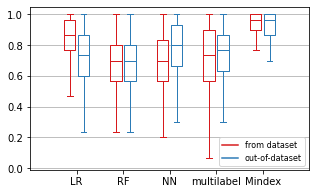

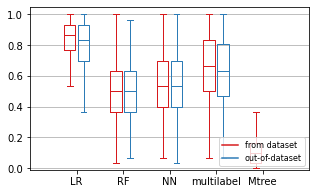

In [43]:
relevant_enums, group_identifier, labels = [MindexOOD, MtreeOOD], 'ood', ['from dataset', 'out-of-dataset']
DIR = '/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs/'

for exp_enum in relevant_enums:
    combinations = get_combinations(exp_enum)
    models = regex_model_names([c[:-1] if c.endswith('-') else c for c in combinations])
    matched_files = [exp_file for exp_file in get_files_in_dir() if re.match(f'^{models}--.*$', exp_file)]
    matched_files = reorder_matched_files(matched_files)
    #print(matched_files)
    #final_candidates = []
    #for comb in [f'{c}-' if c.endswith('-') else c for c in combinations]:
    #    for matched_file in matched_files:
    #        if matched_file.startswith(comb) and not any([f.startswith(comb) for f in final_candidates]):
    #            final_candidates.append(matched_file)
    final_candidates_a = [test_file for test_file in matched_files if group_identifier not in test_file]
    final_candidates_b = [test_file for test_file in matched_files if group_identifier in test_file]
    #assert len(final_candidates_a) == len(final_candidates_b)
    print(final_candidates_a, final_candidates_b)
    ticks = [final_candidate.split('-')[4] for final_candidate in final_candidates_a]

    scores_a = []
    for t in final_candidates_a:
        search = pd.read_csv(f'{DIR}/{t}/search.csv')
        scores_a.append(search[search['condition'] == 50_000]['knn_score'].values)
    scores_b = []
    for t in final_candidates_b:
        search = pd.read_csv(f'{DIR}/{t}/search.csv')
        scores_b.append(search[search['condition'] == 50_000]['knn_score'].values)

    plot_boxplots(
        scores_a,
        scores_b,
        ticks,
        labels=labels,
        save=True,
        filename=f'{group_identifier}-{exp_enum.__name__}',
        dir_to_save_to='outputs/'
    )

In [37]:
df = pd.read_csv('/storage/brno2/home/tslaninakova/exp/learned-indexes-repro/outputs/CoPhIR-1M-Mindex-2000-multilabel-NN--2022-05-17--10-18-05/search.csv')

In [39]:
df[df['condition'] == 50_000]['knn_score'].mean()

0.9037356321839082